In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pims
import pandas as pd

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 25
from matplotlib.animation import FuncAnimation
# import matplotlib.pyplot as plt
# from numba import njit
from scipy.stats import expon,poisson,gamma,goodness_of_fit,ks_2samp,kstest

import os


In [318]:
def calculate_velocities_in_df(dataframe):
    dataframe['dt'] = dataframe.groupby('Track ID')['Frame'].diff()
    dataframe['vx'] = dataframe.groupby('Track ID')['x (micron)'].diff() / (dataframe['dt']*3.335)
    dataframe['vy'] = dataframe.groupby('Track ID')['y (micron)'].diff() / (dataframe['dt']*3.335)
    dataframe['speed'] = np.sqrt(dataframe['vx']**2 + dataframe['vy']**2)

    dataframe['speed'] = dataframe['speed'].fillna(0)
    dataframe['vx'] = dataframe['vx'].fillna(0)
    dataframe['vy'] = dataframe['vy'].fillna(0)
    


    return dataframe.drop(columns=["dt"])

In [191]:

def smooth_speed_calc(speed):
    smooth = np.zeros(len(speed))
    for i in range(len(speed)-1):
        smooth[i] = np.sqrt(speed[i]*speed[i+1])
    smooth[-1] = speed[-1]
    return smooth/max(smooth)

def Corr_2_optimized(T_steps, a, b):
    """
    Computes the normalized autocorrelation function for two input sequences `a` and `b`.

    Parameters:
        T_steps (int): Total number of time steps.
        a (array-like): First input sequence.
        b (array-like): Second input sequence.

    Returns:
        tuple:
            - Corr (numpy.ndarray): Normalized autocorrelation values.
            - tau_time (numpy.ndarray): Corresponding time lags.
    """
    Corr = np.empty(T_steps)
    tau_time = np.empty(T_steps)

    for tau in range(T_steps):
        auxC = 0.0
        for t in range(T_steps - tau):
            auxC += a[t] * a[t + tau] + b[t] * b[t + tau]

        Corr[tau] = auxC / (T_steps - tau)
        tau_time[tau] = tau

    return Corr / Corr[0]  
        

In [95]:
from scipy.stats import chi2_contingency

def compare_histograms_chi2(data1, data2, bins=20, plot=False, label1="Data 1", label2="Data 2",xlabel= "Values"):
    """
    Perform chi-square test on binned histograms of two datasets.
    
    Parameters:
        data1, data2: Arrays of data to compare.
        bins: int or array-like — number of bins or bin edges.
        plot: bool — if True, show histogram plot.
        label1, label2: Optional labels for datasets.
    
    Returns:
        chi2: Chi-square statistic
        pval: p-value
    """
    # Compute histograms
    hist1, bin_edges1 = np.histogram(data1, bins=bins)
    hist2, bin_edges2 = np.histogram(data2, bins=bins)  # same bins!

    # Keep only bins where both are > 0
    mask = (hist1 > 0) & (hist2 > 0)
    contingency = np.array([hist1[mask], hist2[mask]])

    # Chi-square test
    chi2, pval, _, _ = chi2_contingency(contingency, correction=False)

    # Optional plot
    if plot:
        bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2
        bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2
        plt.figure(figsize=(4.5, 4.5),layout='constrained')
        plt.bar(bin_centers1, hist1, width=np.diff(bin_edges1), alpha=0.9, label=label1, align='center')
        plt.bar(bin_centers2, hist2, width=np.diff(bin_edges2), alpha=0.6, label=label2, align='center')
        plt.xlabel(xlabel)
        plt.ylabel("Counts")
        plt.legend(fontsize=16,handlelength=1.5)
        plt.title(f"Chi2 = {chi2:.2f}, p = {pval:.4f}",fontsize=16)
        plt.show()

    return chi2, pval

In [14]:
group_trajs = pd.read_csv('data/group-trajectories/wframes.csv')
dataframe = group_trajs
# dataframe = group_trajs.drop(columns=['Unnamed: 0'])
groups = dataframe['Group'].unique()
# dataframe = dataframe.dropna()
dataframe

,Track ID,x (micron),y (micron),t (sec),Frame,Group,Classification,Together
0,21,9.218501,90.897508,0.000000,0,A,P,FALSE
1,21,9.218501,90.691508,3.334563,1,A,P,FALSE
2,21,9.270001,90.588508,6.669126,2,A,P,FALSE
3,21,9.321501,90.382508,10.003688,3,A,P,FALSE
4,21,9.270001,90.382508,13.338251,4,A,P,FALSE
...,...,...,...,...,...,...,...,...
4563,78,67.014381,39.346004,650.239749,195,H,P,FALSE
4564,78,67.439256,39.268753,653.574312,196,H,P,FALSE
4565,78,67.683881,39.346004,656.908874,197,H,P,FALSE
4566,78,68.134506,39.449004,660.243437,198,H,P,FALSE


# Speed calculation


# distance and velocity cross correlation
Calculating the distance between the CM and the velocity cross correlation between 2 parallel bacteria

In [208]:
dataframe_groups = pd.read_csv('data/group-trajectories/group_traj_video1_wspeedsd_wframes.csv',index_col=0)
groups = dataframe_groups['Group'].unique()

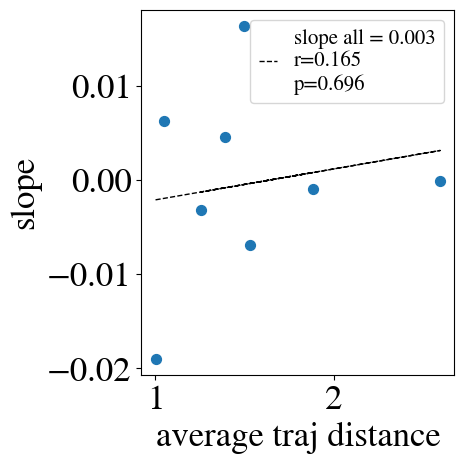

In [209]:
from scipy import stats

distances_all = []
correlations_all = []
# distances_touch = []
# correlations_touch = []
groups = sorted(groups)

slope_all = []
for group in groups[:len(groups)-4]:
    trajs = dataframe_groups[dataframe_groups['Group']==group]
    # a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
    ids = trajs['Track ID'].unique()

    if len(ids) < 3:
        id1,id2 = ids[0],ids[1]
        a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
        part1,part2 = a[a['Track ID'] == ids[0]].sort_values('Frame'),a[a['Track ID'] == ids[1]].sort_values('Frame')
        part1 = part1[part1['Together']=="Y"]
        part2 = part2[part2['Together']=="Y"]
        time = part1['Frame'].unique()
        v1_norm = np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)
        v2_norm = np.sqrt(part2['vx'].values**2 + part2['vy'].values**2)
        x1_x2 = np.abs(part1['x (micron)'].values-part2['x (micron)'].values)
        y1_y2 = np.abs(part1['y (micron)'].values-part2['y (micron)'].values)
        # vx1_normalized = part1['vx'].values/v1_norm
        # vy1_normalized = part1['vy'].values/v1_norm
        # vx2_normalized = part2['vx'].values/v2_norm
        # vy2_normalized = part2['vy'].values/v2_norm
        

        
        # if part1['Frame'].max() != part2['Frame'].max():
        #     min_frames = min(part1['Frame'].max(),part2['Frame'].max())
        #     part1 = part1[part1['Frame']<min_frames]
        #     part2 = part2[part2['Frame']<min_frames]
        

            
        cross_correlation_equal_time = part1['vx'].values*part2['vx'].values + part1['vy'].values*part2['vy'].values
        # cross_correlation_equal_time = cross_correlation_equal_time / (v1_norm*v2_norm)
        # cross_correlation_equal_time = np.nan_to_num(cross_correlation_equal_time)
        distance_equal_time = np.sqrt((part1['x (micron)'].values-part2['x (micron)'].values)**2 + (part1['y (micron)'].values-part2['y (micron)'].values)**2)
        # distance_equal_time = distance_equal_time/np.max(distance_equal_time)
        # mask = (distance_equal_time < th_distance)
        # distances_touch.append(distance_equal_time[mask])
        # correlations_touch.append(cross_correlation_equal_time[mask])
        # distances_all.append(distance_equal_time)
        correlations_all.append(cross_correlation_equal_time)

        # time = a['Frame'].unique()
    slope, intercept, r, p, std_err = stats.linregress(distance_equal_time,cross_correlation_equal_time)
    slope_all.append(slope)
    distances_all.append(np.mean(distance_equal_time))
    # fig,ax = plt.subplots(1,2,figsize=(9,5))


    # ax[0].plot(time,cross_correlation_equal_time/max(cross_correlation_equal_time),marker='o',ms=4,lw=1,label=r'normalized by max $v_1\cdot v_2$')
    # ax[0].plot(time, distance_equal_time/max(distance_equal_time),marker='o',ms=2,lw=1,label=r'normalized by max $|\overrightarrow{r_1}-\overrightarrow{r_2}|$')
    # ax[0].legend(fontsize=12,handlelength=0.9)
    # ax[0].set_xlabel('time (frames)')
    # ax[0].set_xlim((min(time)-3,max(time)+1))
    # ax[1].scatter(distance_equal_time,cross_correlation_equal_time,marker='o',s=8)
    # ax[1].plot(distance_equal_time,slope*distance_equal_time+intercept,ls='--',color='black',lw=1,label=f'slope = {slope:.3}\nr={r:.2f}\np={p:.2f}')
    # ax[1].legend(fontsize=15,handlelength=0.9)
    # ax[1].set_ylabel(r'$v_1\cdot v_2$')
    # ax[1].set_xlabel(r'$|\overrightarrow{r_1}-\overrightarrow{r_2}|$')
   
    # fig.suptitle(f'pair {group} id {id1} and id {id2}',fontsize=20)


    # # 

    # plt.tight_layout(pad=0.5)
    # plt.show()
slope, intercept, r, p, std_err = stats.linregress(distances_all,slope_all)
plt.figure(figsize=(5,5))
# # plt.plot(time,x1_x2,marker='o',ms=5,lw=1,label=r'$|x_1 - x_2|$',color='blue')
plt.scatter(distances_all,slope_all,marker='o',s=50)
plt.plot(distances_all,slope*np.array(distances_all)+intercept,ls='--',color='black',lw=1,label=f'slope all = {slope:.3f}\nr={r:.3f}\np={p:.3f}')
plt.xlabel('average traj distance')
plt.ylabel('slope')
plt.legend(fontsize=15,handlelength=0.9)
plt.tight_layout(pad=0.8)

plt.show()
# plt.plot(time, distance_equal_time,marker='o',ms=2,lw=1,label=r'$|\overrightarrow{r_1}-\overrightarrow{r_2}|$')
# plt.hlines(w,min(time),max(time),ls='--',color='blue',label='width')
# plt.hlines(l,min(time),max(time),ls='--',color='orange',label='length')

# plt.xlabel('time (frames)')
# plt.title(f'pair {group} id {id1} and id {id2}',fontsize=20)
# plt.xticks(time[::20])
# # plt.ylabel(r'$\cos(\theta_{1,2})$')
# plt.legend(fontsize=15,handlelength=1.0)
# plt.tight_layout(pad=0.8)
# plt.show()



# Distance and displacement 

In [ ]:
distances_all = []
displ_all = []
distances_touch = []
displ_touch = []
groups = sorted(groups)
th_distance = 1.5
for group in groups[:len(groups)-4]:
    trajs = dataframe_groups[dataframe_groups['Group']==group]
    # a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
    ids = trajs['Track ID'].unique()

    if len(ids) < 3:
        id1,id2 = ids[0],ids[1]
        a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
        part1,part2 = a[a['Track ID'] == ids[0]].sort_values('Frame'),a[a['Track ID'] == ids[1]].sort_values('Frame')
        
        # if part1['Frame'].max() != part2['Frame'].max():
        #     min_frames = min(part1['Frame'].max(),part2['Frame'].max())
        #     part1 = part1[part1['Frame']<min_frames]
        #     part2 = part2[part2['Frame']<min_frames]
        

            
        displ_equal_time = np.sqrt((part1['x (micron)'].values+part2['x (micron)'].values)**2 + (part1['y (micron)'].values+part2['y (micron)'].values)**2)
        distance_equal_time = np.sqrt((part1['x (micron)'].values-part2['x (micron)'].values)**2 + (part1['y (micron)'].values-part2['y (micron)'].values)**2)
        mask = (distance_equal_time < th_distance)
        distances_touch.append(distance_equal_time[mask])
        displ_touch.append(displ_equal_time[mask])
        distances_all.append(distance_equal_time)
        displ_all.append(displ_equal_time)

    time = a['Frame'].unique()
        
    fig,ax = plt.subplots(2,2,figsize=(10,9.5))

    ax[0,0].plot(time, displ_equal_time, marker='o',ms=1,lw=1)
    ax[0,1].plot(time, distance_equal_time,marker='o',ms=2,lw=1)
    # ax[2].hist2d(displ)
    # ax[0].set_xlim((8,108))
    # plt.tick_params(labelcolor='none', which='', top=False, bottom=False, left=False, right=False)
    ax[0,0].set_ylabel(r'$|\overrightarrow{r_1}+\overrightarrow{r_2}|$')
    ax[0,1].set_ylabel(r'$|\overrightarrow{r_1}-\overrightarrow{r_2}|$')
    for i in range(2):
        ax[0,i].set_xticks(time[::30])
        ax[0,i].set_xlabel('frame')
        
        
    ax[1,0].hist2d(distance_equal_time,displ_equal_time,bins=30)
    ax[1,1].hist2d(distance_equal_time[mask],displ_equal_time[mask],bins=30)
    for j in range(2):
        ax[1,j].set_xlabel(r'$|\overrightarrow{r_1}-\overrightarrow{r_2}|$')
        ax[1,j].set_ylabel(r'$|\overrightarrow{r_1}+\overrightarrow{r_2}|$')
    # ax[1].set_xlim((8,108))

    fig.suptitle(f'pair {group} id {id1} and id {id2}')
    # fig.supxlabel('frame')

    # 

    plt.tight_layout(pad=0.5)
    # plt.savefig(f'data/55_tracks/pairs_config_analysis/ids_{id1}and{id2}_correlation_distance.png',dpi=200)
    plt.show()

# Different time auto correlation

In [25]:
from numba import njit
@njit
def Corr_2_optimized(T_steps, a, b):
    """
    Computes the normalized autocorrelation function for two input sequences `a` and `b`.

    Parameters:
        T_steps (int): Total number of time steps.
        a (array-like): First input sequence.
        b (array-like): Second input sequence.

    Returns:
        tuple:
            - Corr (numpy.ndarray): Normalized autocorrelation values.
            - tau_time (numpy.ndarray): Corresponding time lags.
    """
    Corr = np.empty(T_steps)
    tau_time = np.empty(T_steps)

    for tau in range(T_steps):
        auxC = 0.0
        for t in range(T_steps - tau):
            auxC += a[t] * a[t + tau] + b[t] * b[t + tau]

        Corr[tau] = auxC / (T_steps - tau)
        tau_time[tau] = tau

    return tau_time,Corr / Corr[0]

def cross_corr_2_optimized(T_steps, a1,a2,b1,b2):
    """
    Computes the normalized autocorrelation function for two input sequences `a` and `b`.

    Parameters:
        T_steps (int): Total number of time steps.
        a1 (array-like): first component of particle one.
        a2 (array-like): first component of particle two.
        ...
    Returns:
        tuple:
            - Corr (numpy.ndarray): Normalized autocorrelation values.
            - tau_time (numpy.ndarray): Corresponding time lags.
    """
    Corr = np.empty(T_steps)
    tau_time = np.empty(T_steps)

    for tau in range(T_steps):
        auxC = 0.0
        for t in range(T_steps - tau):
            auxC += a1[t] * a2[t + tau] + b1[t] * b2[t + tau]

        Corr[tau] = auxC / (T_steps - tau)
        tau_time[tau] = tau

    return tau_time, Corr / Corr[0]

In [210]:
corr1_all, corr2_all = [],[]
corr1_touch,corr2_touch = [],[]
distances_all, distances_touch = [],[]
groups = sorted(groups)


for group in groups[:len(groups)-4]:
    trajs = dataframe_groups[dataframe_groups['Group']==group]
    # a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
    ids = trajs['Track ID'].unique()

    if True:
        id1,id2 = ids[0],ids[1]
        a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
        
        part1,part2 = a[a['Track ID'] == ids[0]].sort_values('Frame'),a[a['Track ID'] == ids[1]].sort_values('Frame')
        part1 = part1[part1['Together']=="Y"]
        part2 = part2[part2['Together']=="Y"]
        time = part1['Frame'].values
        vx1,vy1 = part1['vx'].values,part1['vy'].values
  
        vx2,vy2 = part2['vx'].values,part2['vy'].values

        distance_equal_time = np.sqrt((part1['x (micron)'].values-part2['x (micron)'].values)**2 + (part1['y (micron)'].values-part2['y (micron)'].values)**2)

        distances_all.append(distance_equal_time)
        tau1, corr1 = Corr_2_optimized(len(time)-1,vx1,vy1)
        tau2,corr2 = Corr_2_optimized(len(time)-2,vx2,vy2)
        tau_cross, cross_corr = cross_corr_2_optimized(len(time)-1,vx1,vx2,vy1,vy2)
       
       
        
       
        fig1,ax2 = plt.subplots(1,2,figsize=(7,4.2))
     
        
        ax2[0].plot(tau1,corr1,marker='o',ms=1.5,lw=1,label=r'$C_1$',color='green')
        ax2[0].plot(tau2,corr2,marker='o',ms=1.5,lw=1,label=r'$C_2$',color='red')
        ax2[1].plot(tau_cross,cross_corr,marker='o',ms=1.5,lw=1,label=r'$C_{12}$',color='blue')
        for a in ax2:
            a.legend(fontsize=12,handlelength=0.5)
            a.set_xlabel(r'$\tau$')
        
       
        
        fig1.suptitle(f'pair {group} id {id1} and id {id2}',fontsize=20,y=0.85)

        plt.tight_layout()
        plt.show()
        
        
        
            
            
        
        
        

ValueError: too many values to unpack (expected 2)

## moving-not-moving 

In [7]:
def autocorrelation(series):
    """Compute the normalized autocorrelation function of a time series."""
    series = np.array(series) - np.mean(series)  # Remove mean
    n = len(series)
    norm = np.var(series) * n  # Normalization factor
    result = np.correlate(series, series, mode="full") / norm  # Compute autocorrelation
    return result[n-1:] 


def find_zero_crossing_lag(acf):
    """Find the first zero crossing lag of the autocorrelation function."""
    indices = np.where(np.sign(acf[:-1]) != np.sign(acf[1:]))[0]
    return indices[0] if len(indices) > 0 else None

def cross_correlation(signal1, signal2):
    """Compute normalized cross-correlation between two signals."""
    signal1 = np.asarray(signal1)
    signal2 = np.asarray(signal2)

    if len(signal1) != len(signal2):
        raise ValueError("Signals must be of the same length")

    # Remove mean
    signal1 = signal1 - np.mean(signal1)
    signal2 = signal2 - np.mean(signal2)

    # Normalize
    norm = np.std(signal1) * np.std(signal2) * len(signal1)
    
    # Full cross-correlation
    cc = np.correlate(signal1, signal2, mode='full') / norm

    # Return only positive lags (or full if you prefer)
    return cc[len(signal1)-1:]  # full lags: from -N+1 to N-1

def hist_calc(data,bins):
    bins = np.histogram_bin_edges(data,bins = bins)
    hist,bins = np.histogram(data,bins=bins,density=True)
    bins_centers = 0.5*(bins[1:]+bins[:-1])
    return hist,bins_centers
from scipy.stats import chisquare

def compare_gamma_poisson(a):
    # Fit gamma (continuous)
    shape, loc, scale = gamma.fit(a, floc=0.0)
    ks_stat, ks_p = kstest(a, 'gamma', args=(shape, loc, scale))

    # Fit Poisson (discrete)
    a_rounded = np.round(a).astype(int)
    a_rounded = a_rounded[a_rounded >= 0]  # Poisson only defined for non-neg ints
    lam = np.mean(a_rounded)


    values, counts = np.unique(a_rounded, return_counts=True)
    expected = poisson.pmf(values, mu=lam,loc=-a.min()) * len(a_rounded)

    # Normalize expected to match observed count sum exactly
    expected *= counts.sum() / expected.sum()

    # Avoid zero expected counts
    mask = expected > 0
    chi_stat, chi_p = chisquare(counts[mask], f_exp=expected[mask])

    return {
        'gamma': {'statistic': ks_stat, 'pvalue': ks_p},
        'poisson': {'statistic': chi_stat, 'pvalue': chi_p},
    }
    
def chi2_test_continuous_fit(data, dist, params, bins='auto'):
    # Histogram of observed data
    hist, bin_edges = np.histogram(data, bins=bins)
    
    # CDF to compute expected counts
    cdf_vals = dist.cdf(bin_edges, *params)
    expected = np.diff(cdf_vals) * len(data)
    
    # Rescale expected to match observed total
    expected *= hist.sum() / expected.sum()
    
    # Only keep bins where expected count is sufficient
    mask = expected >= 0
    chi2, p = chisquare(hist[mask], f_exp=expected[mask])
    return chi2, p

In [3]:
def mov_not_mov(A,th):
    """
    Calculate moving and non moving steps.
    
    
    -----------
    A = array with the values to be analyzed, it can be the smoothed speed or the speed 
    
    th = threshold (taken from the prob of moving and prob of not moving)
    
    Return
    -------
    
    tuple: 
    
    (ns,ms,signal) = (list with NOT moving steps, list with MOVING steps,binary signal (+1 if this step and the next is above threshold, 0 if below))
     
    """
    
    # mask is an array that in each element has True if the value of array A is less than the threshold
    mask = A <= th
    signal = [] # binary signal

    
    n=0 # counter for non moving steps
    m=0 # counter for moving steps
    ns=[] # list with consecutive non moving steps
    ms = [] # list with consecutive moving steps
    
    for i in range(len(A)-1):
        
        if mask[i] == True and mask[i+1] == True: # if this value in A and the next are below the threshold
            
            # print('n=',n)
            if m!=0: # append the current running value of m if we changed from moving to non moving
                
                ms.append(m)
            m=0 # reset the counter for moving steps
            signal.append(0) # append 0 to the signal
            n+=1 # begin counting non moving steps
        elif mask[i] == False or mask[i+1] == False: 
            # same as before but with the opposite condition
            if n!=0:
                
                ns.append(n)
            n=0
            signal.append(1)
            m+=1
        if i+1 == len(A)-1: 
            # if we are in the last element of A, we append the last values of n,m and the signal
            if mask[i] == False or mask[i+1] == False:
                signal.append(1)
                ms.append(m)
            else:
                signal.append(0)
                ns.append(n)
    return ns,ms,signal, mask
            

# Groups of 2 

Distance between bacteria and velocity projection

/var/folders/j9/6bbx4y9507q6m64lhqtly8tc0000gn/T/ipykernel_25981/654641428.py:17: RuntimeWarning: invalid value encountered in divide
  same_time_corr = same_time_corr/ (np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)*np.sqrt(part2['vx'].values**2 + part2['vy'].values**2))


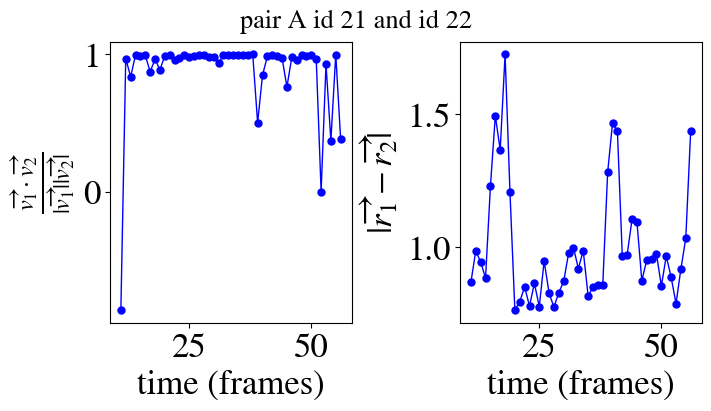

/var/folders/j9/6bbx4y9507q6m64lhqtly8tc0000gn/T/ipykernel_25981/654641428.py:17: RuntimeWarning: invalid value encountered in divide
  same_time_corr = same_time_corr/ (np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)*np.sqrt(part2['vx'].values**2 + part2['vy'].values**2))


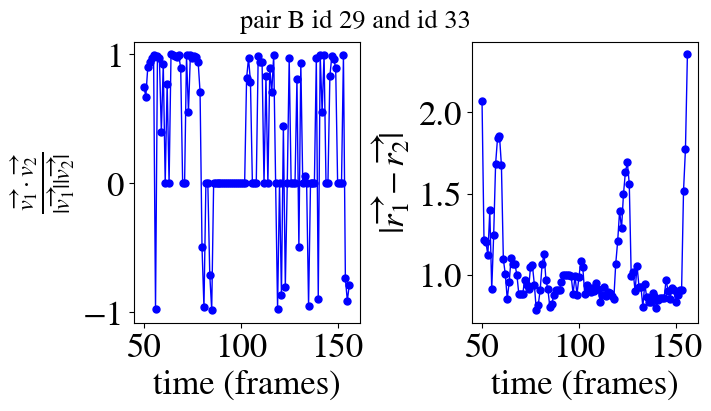

/var/folders/j9/6bbx4y9507q6m64lhqtly8tc0000gn/T/ipykernel_25981/654641428.py:17: RuntimeWarning: invalid value encountered in divide
  same_time_corr = same_time_corr/ (np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)*np.sqrt(part2['vx'].values**2 + part2['vy'].values**2))


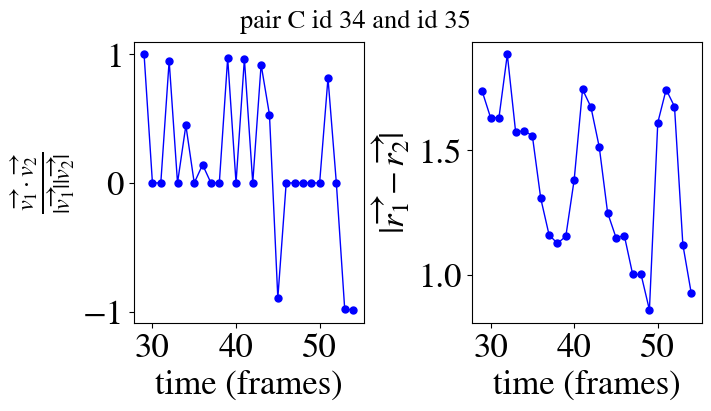

/var/folders/j9/6bbx4y9507q6m64lhqtly8tc0000gn/T/ipykernel_25981/654641428.py:17: RuntimeWarning: invalid value encountered in divide
  same_time_corr = same_time_corr/ (np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)*np.sqrt(part2['vx'].values**2 + part2['vy'].values**2))


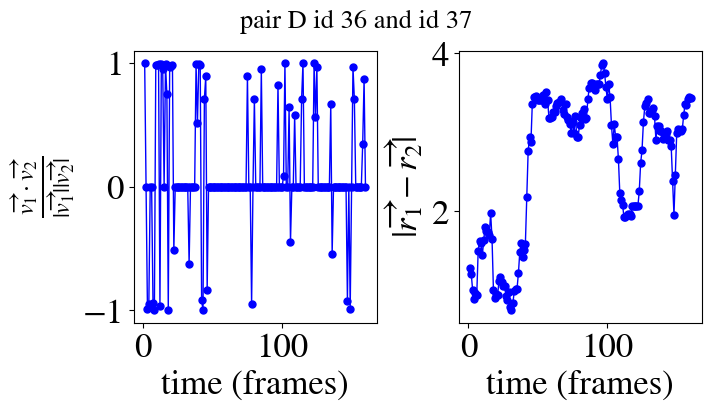

/var/folders/j9/6bbx4y9507q6m64lhqtly8tc0000gn/T/ipykernel_25981/654641428.py:17: RuntimeWarning: invalid value encountered in divide
  same_time_corr = same_time_corr/ (np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)*np.sqrt(part2['vx'].values**2 + part2['vy'].values**2))


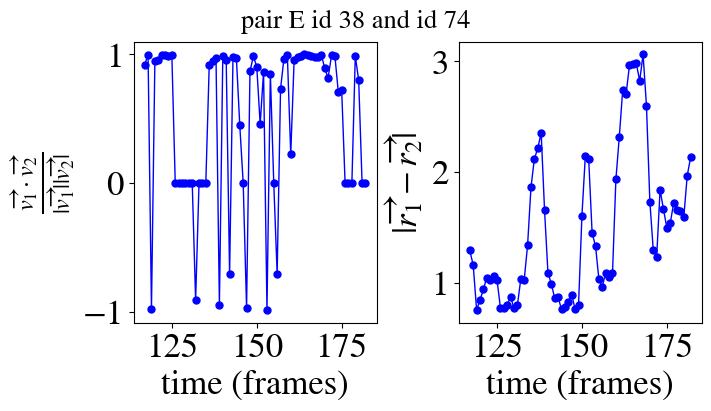

/var/folders/j9/6bbx4y9507q6m64lhqtly8tc0000gn/T/ipykernel_25981/654641428.py:17: RuntimeWarning: invalid value encountered in divide
  same_time_corr = same_time_corr/ (np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)*np.sqrt(part2['vx'].values**2 + part2['vy'].values**2))


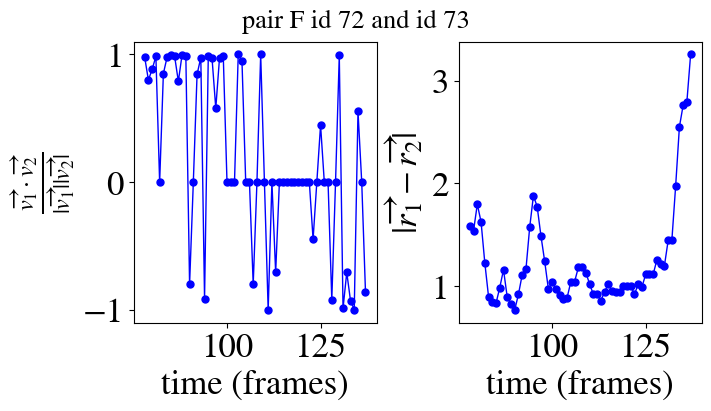

/var/folders/j9/6bbx4y9507q6m64lhqtly8tc0000gn/T/ipykernel_25981/654641428.py:17: RuntimeWarning: invalid value encountered in divide
  same_time_corr = same_time_corr/ (np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)*np.sqrt(part2['vx'].values**2 + part2['vy'].values**2))


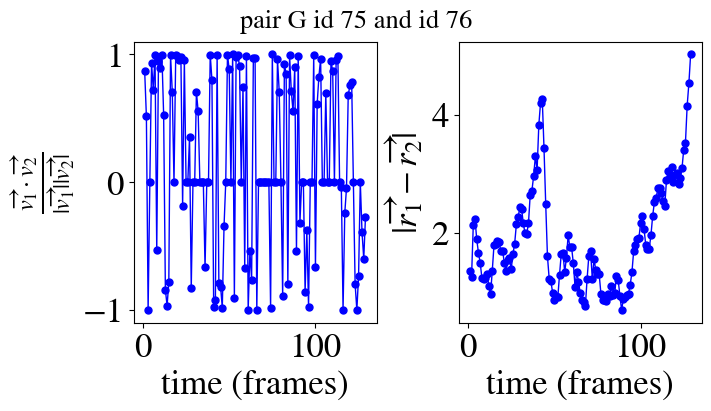

/var/folders/j9/6bbx4y9507q6m64lhqtly8tc0000gn/T/ipykernel_25981/654641428.py:17: RuntimeWarning: invalid value encountered in divide
  same_time_corr = same_time_corr/ (np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)*np.sqrt(part2['vx'].values**2 + part2['vy'].values**2))


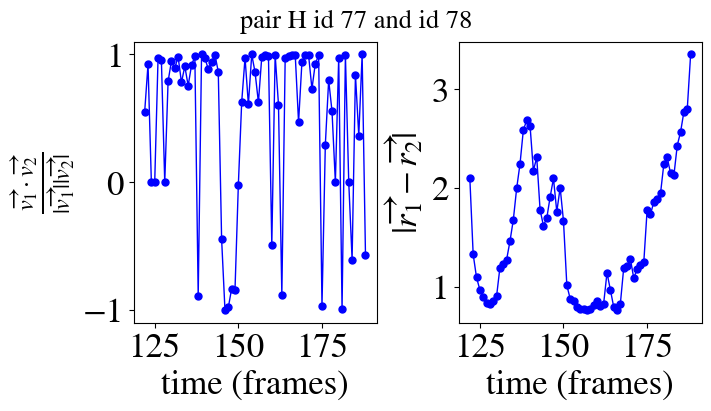

In [294]:
for group in groups[:len(groups)-4]:
    trajs = dataframe_groups[dataframe_groups['Group']==group]
        # a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
    ids = trajs['Track ID'].unique()
    
    id1,id2 = ids[0],ids[1]
    a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
    part1,part2 = a[a['Track ID'] == ids[0]].sort_values('Frame'),a[a['Track ID'] == ids[1]].sort_values('Frame')

    # part1,part2 = a[a['Track ID'] == ids[0]].sort_values('Frame'),a[a['Track ID'] == ids[1]].sort_values('Frame')
    part1 = part1[part1['Together']=="Y"]
    part2 = part2[part2['Together']=="Y"]
    time1 = part1['Frame'].values
    time2 = part2['Frame'].values
    distance_equal_time = np.sqrt((part1['x (micron)'].values-part2['x (micron)'].values)**2 + (part1['y (micron)'].values-part2['y (micron)'].values)**2)
    same_time_corr = part1['vx'].values*part2['vx'].values + part1['vy'].values*part2['vy'].values
    same_time_corr = same_time_corr/ (np.sqrt(part1['vx'].values**2 + part1['vy'].values**2)*np.sqrt(part2['vx'].values**2 + part2['vy'].values**2))
    same_time_corr = np.nan_to_num(same_time_corr)
    fig,ax = plt.subplots(1,2,figsize=(7,4),layout='constrained')
    ax[0].plot(time1,same_time_corr,marker='o',ms=5,color='blue',lw=1)
    ax[0].set_ylabel(r'$\frac{\overrightarrow{v_1}\cdot\overrightarrow{v_2}}{|\overrightarrow{v_1}||\overrightarrow{v_2}|}$')
    ax[0].set_xlabel('time (frames)')
    ax[1].plot(time1,distance_equal_time,marker='o',ms=5,color='blue',lw=1)
    ax[1].set_ylabel(r'$|\overrightarrow{r_1}-\overrightarrow{r_2}|$')
    ax[1].set_xlabel('time (frames)')
    fig.suptitle(f'pair {group} id {id1} and id {id2}',fontsize=19)
    plt.show()
    

Testing if there are any lagged correlation

Max cross-correlation: 0.398 at lag -23
Zero-lag cross-correlation: 0.380
✅ These particles are most correlated with a time delay (non-zero lag).


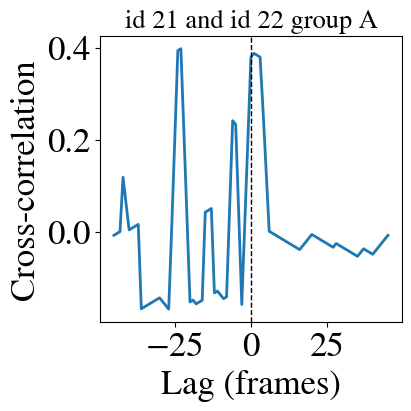

Max cross-correlation: 0.552 at lag -8
Zero-lag cross-correlation: 0.514
✅ These particles are most correlated with a time delay (non-zero lag).


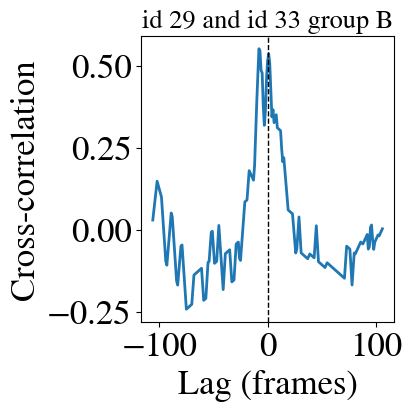

Max cross-correlation: 0.253 at lag 3
Zero-lag cross-correlation: 0.207
✅ These particles are most correlated with a time delay (non-zero lag).


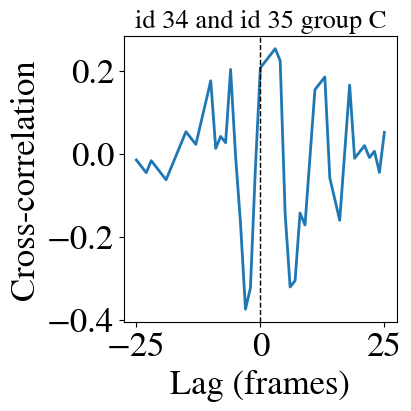

Max cross-correlation: 0.298 at lag 2
Zero-lag cross-correlation: 0.152
✅ These particles are most correlated with a time delay (non-zero lag).


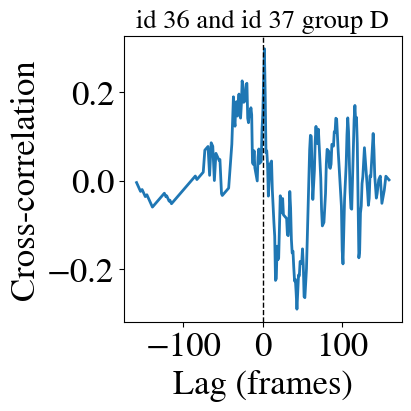

Max cross-correlation: 0.390 at lag -3
Zero-lag cross-correlation: 0.370
✅ These particles are most correlated with a time delay (non-zero lag).


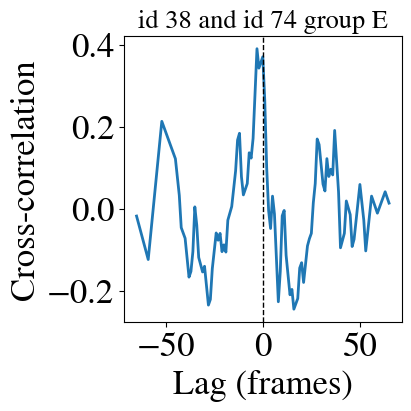

Max cross-correlation: 0.646 at lag -4
Zero-lag cross-correlation: 0.408
✅ These particles are most correlated with a time delay (non-zero lag).


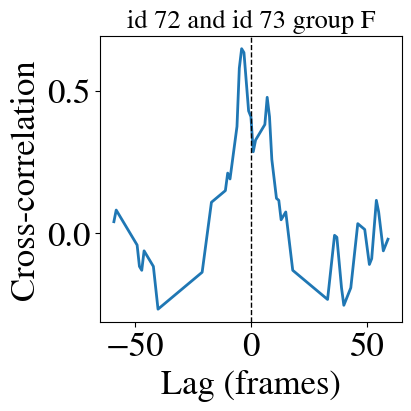

Max cross-correlation: 0.271 at lag 30
Zero-lag cross-correlation: -0.007
✅ These particles are most correlated with a time delay (non-zero lag).


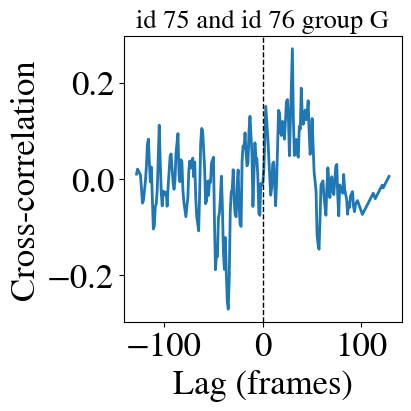

Max cross-correlation: 0.367 at lag -2
Zero-lag cross-correlation: 0.271
✅ These particles are most correlated with a time delay (non-zero lag).


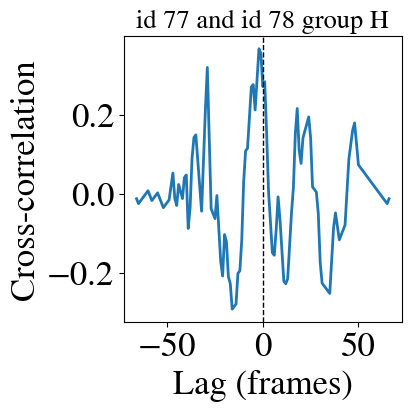

In [297]:
from scipy.signal import correlate
from scipy.stats import zscore

for group in groups[:len(groups)-4]:
    trajs = dataframe_groups[dataframe_groups['Group']==group]
        # a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
    ids = trajs['Track ID'].unique()
    
    id1,id2 = ids[0],ids[1]
    a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
    part1,part2 = a[a['Track ID'] == ids[0]].sort_values('Frame'),a[a['Track ID'] == ids[1]].sort_values('Frame')

    # part1,part2 = a[a['Track ID'] == ids[0]].sort_values('Frame'),a[a['Track ID'] == ids[1]].sort_values('Frame')
    part1 = part1[part1['Together']=="Y"]
    part2 = part2[part2['Together']=="Y"]
    time1 = part1['Frame'].values
    time2 = part2['Frame'].values
    smooth_speed1 = smooth_speed_calc(part1['speed'].values)
    # smooth_speed1 = smooth_speed1/np.max(smooth_speed1)
    smooth_speed2 = smooth_speed_calc(part2['speed'].values)
    # smooth_speed2 = smooth_speed2/np.max(smooth_speed2)
    
    not_moving1,moving1,signal1,mask1 = mov_not_mov(smooth_speed1,0.33)
    not_moving2,moving2,signal2,mask2 = mov_not_mov(smooth_speed2,0.33)

# Normalize speeds (zero mean, unit variance)
    speed1_z = zscore(signal1)
    speed2_z = zscore(signal2)

    # Full cross-correlation
    cross_corr = correlate(speed1_z, speed2_z, mode='full')
    lags = np.arange(-len(signal1) + 1, len(signal2))
    cross_corr /= len(signal1)  # Normalize

    # Identify the maximum correlation and its lag
    max_corr_idx = np.argmax(cross_corr)
    max_corr_lag = lags[max_corr_idx]
    max_corr_value = cross_corr[max_corr_idx]
    zero_lag_value = cross_corr[np.where(lags == 0)[0][0]]
    
    print(f"Max cross-correlation: {max_corr_value:.3f} at lag {max_corr_lag}")
    print(f"Zero-lag cross-correlation: {zero_lag_value:.3f}")

    if max_corr_lag != 0:
        print("✅ These particles are most correlated with a time delay (non-zero lag).")
    else:
        print("⚠️ These particles are most correlated at the same time (zero lag).")

    # Plot
    plt.figure(figsize=(4,4),layout='constrained')
    plt.plot(lags, cross_corr, lw=2)
    plt.axvline(0, color='k', linestyle='--', lw=1)
    plt.title(f'id {id1} and id {id2} group {group}',fontsize=19)
    plt.xlabel('Lag (frames)')
    plt.ylabel('Cross-correlation')
    plt.show()
    
    

In [298]:
def lagged_cross_correlation(speed1, speed2):
    speed1_z = zscore(speed1)
    speed2_z = zscore(speed2)
    cross_corr = correlate(speed1_z, speed2_z, mode='full')
    lags = np.arange(-len(speed1) + 1, len(speed1))
    cross_corr /= len(speed1)
    return cross_corr, lags

def permutation_test(speed1, speed2, num_perm=1000):
    real_corr, lags = lagged_cross_correlation(speed1, speed2)
    real_max = np.max(np.abs(real_corr))
    real_zero = real_corr[np.where(lags == 0)[0][0]]
    real_lag = lags[np.argmax(np.abs(real_corr))]

    perm_max_vals = []
    for _ in range(num_perm):
        shuffled = np.random.permutation(speed2)
        corr, _ = lagged_cross_correlation(speed1, shuffled)
        perm_max_vals.append(np.max(np.abs(corr)))

    p_value = np.mean(np.array(perm_max_vals) >= np.abs(real_max))

    return {
        'real_max_corr': real_max,
        'zero_lag_corr': real_zero,
        'best_lag': real_lag,
        'p_value': p_value,
        'is_lagged': real_lag != 0 and p_value < 0.05
    }

In [302]:
results = []

for group in groups[:len(groups)-4]:
    trajs = dataframe_groups[dataframe_groups['Group'] == group]
    ids = trajs['Track ID'].unique()
    if len(ids) < 2:
        continue

    a = pd.concat([trajs[trajs.duplicated('Frame', keep='last')],
                   trajs[trajs.duplicated('Frame', keep='first')]])
    part1 = a[(a['Track ID'] == ids[0]) & (a['Together'] == 'Y')].sort_values('Frame')
    part2 = a[(a['Track ID'] == ids[1]) & (a['Together'] == 'Y')].sort_values('Frame')

    if len(part1) < 10 or len(part2) < 10:
        continue  # Skip short trajectories

    smooth_speed1 = smooth_speed_calc(part1['speed'].values)
    # smooth_speed1 = smooth_speed1/np.max(smooth_speed1)
    smooth_speed2 = smooth_speed_calc(part2['speed'].values)
    # smooth_speed2 = smooth_speed2/np.max(smooth_speed2)
    
    not_moving1,moving1,signal1,mask1 = mov_not_mov(smooth_speed1,0.33)
    not_moving2,moving2,signal2,mask2 = mov_not_mov(smooth_speed2,0.33)

    if len(signal1) != len(signal2):
        continue  # Make sure they’re aligned

    stats = permutation_test(signal1, signal2, num_perm=1000)
    stats['group'] = group
    stats['id1'], stats['id2'] = ids[0], ids[1]
    results.append(stats)

True     5
False    3
Name: is_lagged, dtype: int64


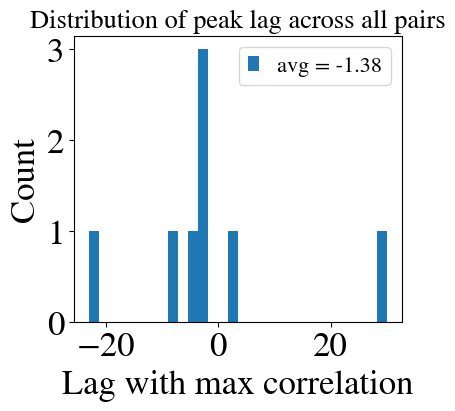

In [305]:
df_results = pd.DataFrame(results)
print(df_results['is_lagged'].value_counts())
plt.figure(figsize=(4,4),layout='constrained')
plt.hist(df_results['best_lag'], bins=30,label=f'avg = {df_results["best_lag"].mean():.2f}')
plt.xlabel('Lag with max correlation')
plt.ylabel('Count')
plt.title('Distribution of peak lag across all pairs',fontsize=19)
plt.legend(fontsize=16,handlelength=0.5)
plt.show()

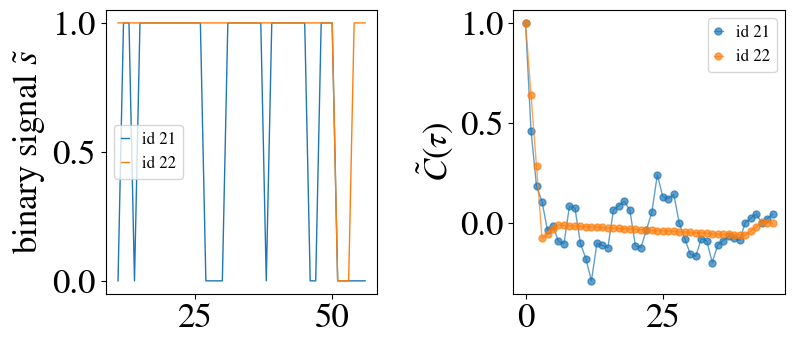

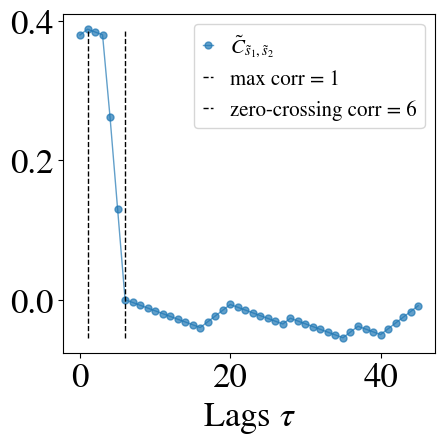

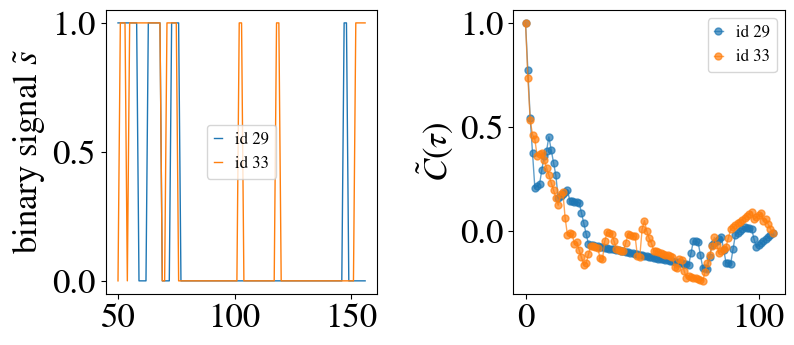

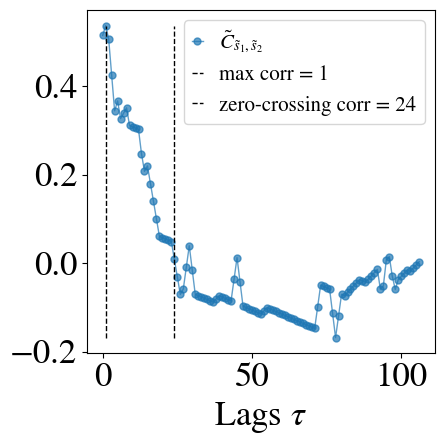

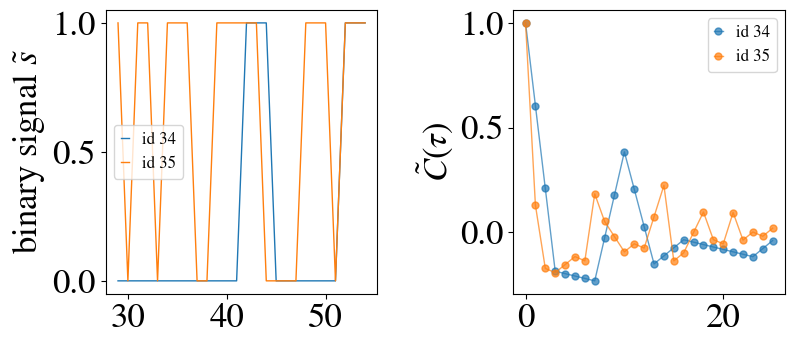

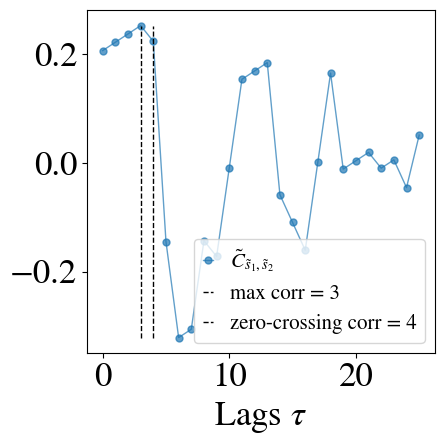

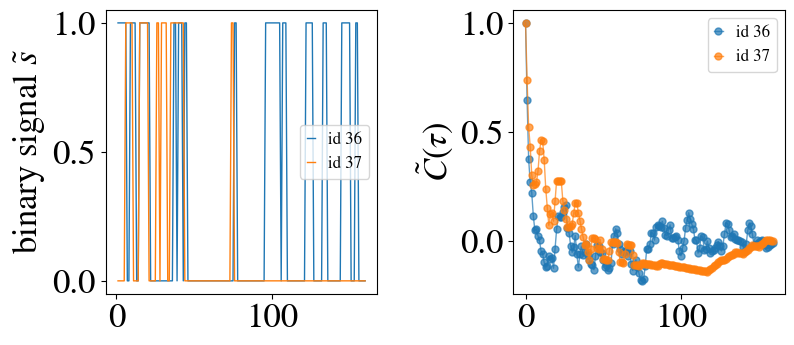

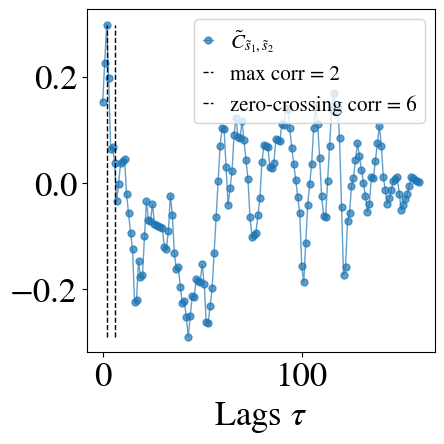

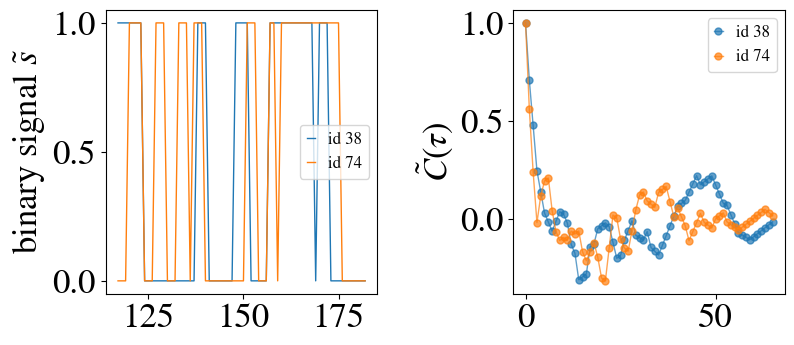

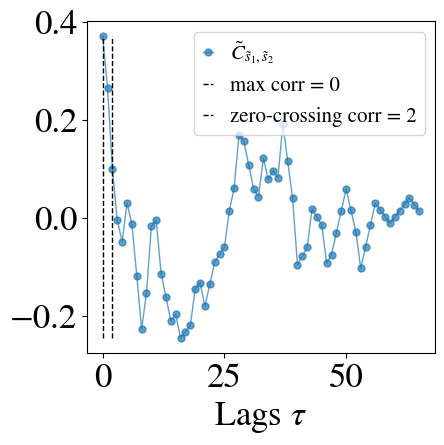

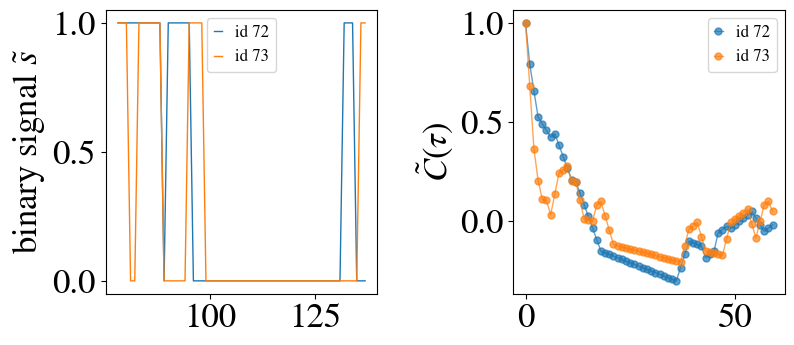

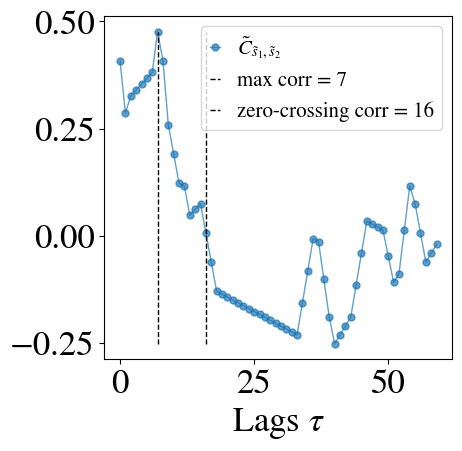

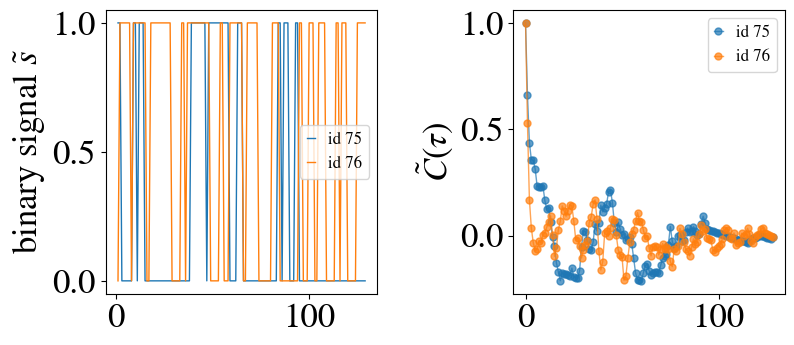

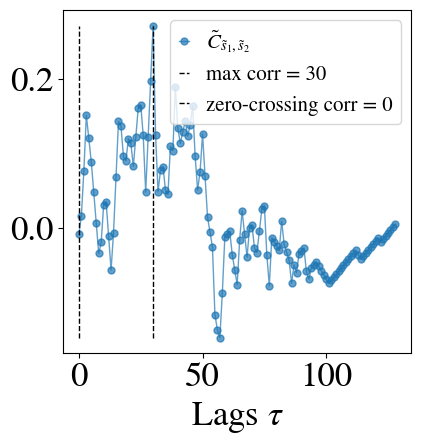

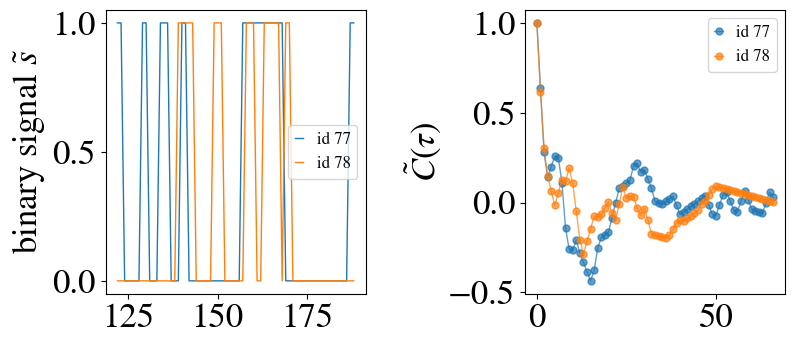

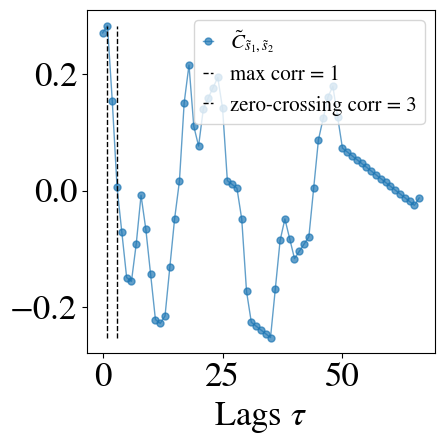

In [211]:
groups= sorted(groups)

moving_all=[]
not_moving_all = []
zero_cross_all = []
max_corr_all = []
for group in groups[:len(groups)-4]:
    # if group == 'G' or group == 'H':
# for group in groups[0]:
    if True:
        trajs = dataframe_groups[dataframe_groups['Group']==group]
        # a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
        ids = trajs['Track ID'].unique()
        
        id1,id2 = ids[0],ids[1]
        a = pd.concat([trajs[trajs.duplicated('Frame',keep='last')],trajs[trajs.duplicated('Frame',keep='first')]])
        part1,part2 = a[a['Track ID'] == ids[0]].sort_values('Frame'),a[a['Track ID'] == ids[1]].sort_values('Frame')

        # part1,part2 = a[a['Track ID'] == ids[0]].sort_values('Frame'),a[a['Track ID'] == ids[1]].sort_values('Frame')
        part1 = part1[part1['Together']=="Y"]
        part2 = part2[part2['Together']=="Y"]
        time1 = part1['Frame'].values
        time2 = part2['Frame'].values
        distance_equal_time = np.sqrt((part1['x (micron)'].values-part2['x (micron)'].values)**2 + (part1['y (micron)'].values-part2['y (micron)'].values)**2)
    
        smooth_speed1 = smooth_speed_calc(part1['speed'].values)
        # smooth_speed1 = smooth_speed1/np.max(smooth_speed1)
        smooth_speed2 = smooth_speed_calc(part2['speed'].values)
        # smooth_speed2 = smooth_speed2/np.max(smooth_speed2)
        
        not_moving1,moving1,signal1,mask1 = mov_not_mov(smooth_speed1,0.33)
        not_moving2,moving2,signal2,mask2 = mov_not_mov(smooth_speed2,0.33)
        color1 = ['blue' if i ==0 else 'red' for i in signal1]
        color2 = ['blue' if i ==0 else 'red' for i in signal2]
        signal1_autocorr = autocorrelation(signal1)
        signal2_autocorr = autocorrelation(signal2)
        lags1 = np.arange(len(signal1_autocorr))
        lags2 = np.arange(len(signal2_autocorr))
        cross_corr_signal = cross_correlation(signal1,signal2)
        max_tau = np.argmax(cross_corr_signal)
        zero_crossing = find_zero_crossing_lag(cross_corr_signal)
        lags = np.arange(-len(signal1)+1, len(signal1))
        moving_all.append(moving1+moving2)
        not_moving_all.append(not_moving1+not_moving2)
        zero_cross_all.append(zero_crossing)
        max_corr_all.append(max_tau)


        
        # plt.figure(figsize=(5,5))
        fig, ax = plt.subplots(1,2,figsize=(8.5,4))
        
        ax[0].plot(time1,signal1,label = f'id {id1}',lw=1.0)
        ax[0].plot(time2,signal2,label = f'id {id2}',lw=1.0)
        ax[0].legend(fontsize=12,handlelength=0.5)
        ax[0].set_ylabel(r'binary signal $\tilde{s}$')
        
        ax[1].plot(lags1,signal1_autocorr,'o-',label=f'id {id1}',lw=1.0,ms=5,alpha=0.7)
        ax[1].plot(lags2,signal2_autocorr,'o-',label=f'id {id2}',lw=1.0,ms=5,alpha=0.7)
        ax[1].set_ylabel(r'$\tilde{C}(\tau)$')
        ax[1].legend(fontsize=12,handlelength=0.5)

        # plt.scatter(time1,smooth_speed1,marker='o',s=22,c=color1)
        # plt.plot(time1,smooth_speed1,lw=1.5,color='green',label = f'id {id1}')
        # plt.plot(time2,smooth_speed2,lw=1.5,color='orange',label = f'id {id2}')

        # plt.scatter(time2,smooth_speed2,marker='o',s=22,c=color2)
        # plt.ylabel('smooth speed')
        # plt.xlabel('time (frame)')
        # plt.legend(fontsize=12,handlelength=0.5)
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(5,5))
        plt.plot(lags1,cross_corr_signal,'o-',label=r'$\tilde{C}_{\tilde{s}_1,\tilde{s}_2}$',lw=1.0,ms=5,alpha=0.7)
        plt.vlines(max_tau,min(cross_corr_signal),max(cross_corr_signal),ls='--',color='black',lw=1.0,label= f'max corr = {max_tau}')
        plt.vlines(zero_crossing,min(cross_corr_signal),max(cross_corr_signal),ls='--',color='black',lw=1.0,label= f'zero-crossing corr = {zero_crossing}')

        plt.xlabel(r'Lags $\tau$')
        plt.legend(fontsize=15,handlelength=0.5)
        plt.tight_layout()
        plt.show()
        
    

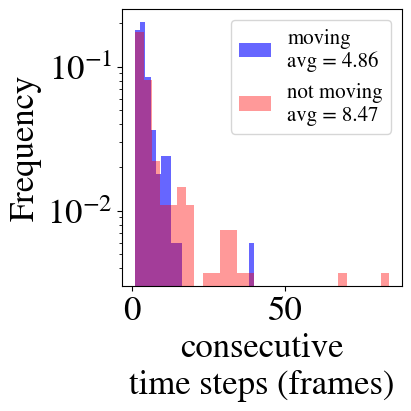

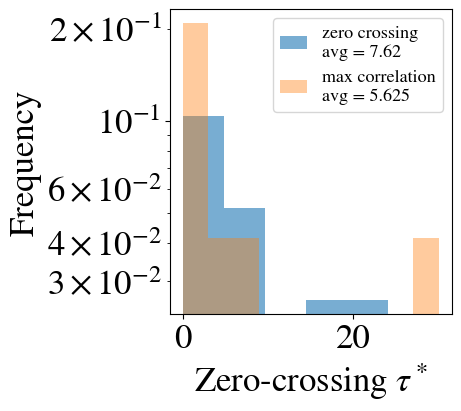

In [212]:
moving_all_pairs = np.hstack(moving_all)
not_moving_all_pairs = np.hstack(not_moving_all)


# y1 = poisson.pmf(np.arange(moving_all.max()),np.mean(moving_all),loc=-moving_all.min())
# params = gamma.fit(moving_all,floc=0.0)
# y = gamma.pdf(np.arange(moving_all.max()),*params)
# shape,loc,scale=params
# fig, ax = plt.subplots(1,2,figsize=(9,4.5),layout='constrained')

# ax[0].hist(moving_all,bins='auto',label=f'moving avg = {moving_all.mean():.2f}',color='blue',density=True,alpha=0.6)
# # ax[0].plot(np.arange(moving_all.max()),y,color='black',label='gamma:\nshape = %.3f\nloc = %.3f\nscale = %.3f' %params)
# # ax[0].plot(np.arange(moving_all.max()),y1,color='red',label='poisson')
# ax[0].hist(not_moving_all, bins='auto', label = f'not moving avg = {not_moving_all.mean():.2f}',color='red',density=True,alpha=0.4)
# ax[0].set_xlabel('consecutive time steps (frames)',fontsize=19)
# ax[1].hist(zero_cross_all,bins='auto',label=f'zero crossing avg = {np.mean(zero_cross_all):.2f}',density=True,alpha=0.6)
# ax[1].hist(max_corr_all,bins='auto',label=f'max correlation avg = {np.mean(max_corr_all):.3f}',density=True,alpha=0.4)
# ax[1].set_xlabel(r'$\tau$')
# # ax[0].plot(mv[1],mv[0],marker='o',ms=10,lw=0,label='moving',color='black')
# # ax[1].plot(nm[1],nm[0],marker='o',ms=10,lw=0,label='not moving',color='black')

# ax[0].set_ylabel('Frequency')
# for a in ax:
#     a.legend(fontsize=14,handlelength=1.5)
#     a.semilogy()
#     # a.set_xlabel('consecutime steps (frames)')
# # fig.supxlabel('consecutive time steps (frames)',y=-0.09)
# # plt.tight_layout()
# # plt.savefig('data/group-trajectories/distribution_moving_tau_crossings_pairs1.pdf',bbox_inches= 'tight',dpi=200)
# plt.show()
fig1, ax1 = plt.subplots(figsize=(4,4), layout='constrained')

ax1.hist(moving_all_pairs, bins='auto',
         label=f'moving\navg = {moving_all_pairs.mean():.2f}',
         color='blue', density=True, alpha=0.6)

ax1.hist(not_moving_all_pairs, bins='auto',
         label=f'not moving\navg = {not_moving_all_pairs.mean():.2f}',
         color='red', density=True, alpha=0.4)

ax1.set_xlabel('consecutive\ntime steps (frames)')
ax1.set_ylabel('Frequency')
ax1.legend(fontsize=15, handlelength=1.5)
ax1.semilogy()

# fig1.savefig('data/group-trajectories/distribution_moving_not_moving_only_pairs1.pdf',
#              bbox_inches='tight', dpi=200)
plt.show()

# Second figure: zero crossing vs. max correlation
fig2, ax2 = plt.subplots(figsize=(4.5,4), layout='constrained')

ax2.hist(zero_cross_all, bins='auto',
         label=f'zero crossing\navg = {np.mean(zero_cross_all):.2f}',
         density=True, alpha=0.6)

ax2.hist(max_corr_all, bins='auto',
         label=f'max correlation\navg = {np.mean(max_corr_all):.3f}',
         density=True, alpha=0.4)

ax2.set_xlabel(r'Zero-crossing $\tau^*$')
ax2.set_ylabel('Frequency')
ax2.legend(fontsize=13, handlelength=1.5)
ax2.semilogy()

# fig2.savefig('data/group-trajectories/distribution_zero_crossings_maxcorr_pairs1.pdf',
#              bbox_inches='tight', dpi=200)
plt.show()

# video


In [ ]:
frames = pims.open('data/group-trajectories/second_wave/frames/*.tif')
ids = dataframe['Track ID'].unique()
pairs = [(list(), list()) for _ in range(len(ids))]
x1, y1 = zip(*pairs)
fig_movie, ax_movie = plt.subplots(figsize=(10,10))

# for frame in range(frames):
for frame in range(200):
    ax_movie.clear()
    # print(f'frame {frame}')
    ax_movie.imshow(frames[frame],cmap='Greys',alpha=0.7,origin='lower')
    for i,id in enumerate(ids):
        
        traj= dataframe[dataframe['Track ID'] == id].sort_values('Frame')
        first_frame = min(traj['Frame'].values)
        # aux_this_frame = traj[traj['Frame'] == frame]
        
        # print(traj.values.shape[0],frame)
        
        if (frame < traj.values.shape[0]) and (first_frame <= frame):
            X = traj[traj['Frame'] == frame]['x (micron)'].values[0]
            Y = traj[traj['Frame'] == frame]['y (micron)'].values[0]
            x1[i].append(X*9.7087)
            y1[i].append(Y*9.7087)
            ax_movie.annotate(f'id {int(id)}',xy=(x1[i][-1],y1[i][-1]),fontsize=17,color='black',weight='bold')
            
        # print(i,id,x1[i],y1[i])
        ax_movie.plot(x1[i],y1[i],marker='o', mfc='none',ms=0, lw=1.4)
        
    
    ax_movie.set_xlabel(r'x (px)',fontsize=22)
    ax_movie.set_ylabel(r'y (px)',fontsize=22)
    ax_movie.set_title(f'frame {frame}',fontsize=16,loc='left')

    ax_movie.tick_params(axis='both', labelsize=22)
    # plt.tight_layout()
    plt.savefig(f'data/group-trajectories/second_wave/frames/frame2_{frame:03d}.png',dpi=200,bbox_inches="tight")
    # plt.show()
        
# ani = FuncAnimation(fig_movie,animate, frames=150, interval=30, repeat=False)

# HTML(ani.to_jshtml())     

# New data

In [216]:
dataframe = pd.read_csv('data/group-trajectories/second_wave/isolated_pairs_video1_v2_wspeeds.csv',index_col = 0)
ids = dataframe['Track ID'].unique()
dataframe


,Track ID,x (micron),y (micron),t (sec),Frame,Info,Obs,vx,vy,speed
Spot ID,,,,,,,,,,
2001,0,32.908503,33.861253,0.000000,0,Isolated,None,0.000000,0.000000,0.000000
2064,0,32.882753,33.887003,3.334563,1,Isolated,None,-0.007721,0.007721,0.010919
2068,0,32.779753,33.475003,6.669126,2,Isolated,None,-0.030885,-0.123538,0.127340
2071,0,32.728253,33.063003,10.003688,3,Isolated,None,-0.015442,-0.123538,0.124500
2073,0,32.857003,33.217503,13.338251,4,Isolated,None,0.038606,0.046327,0.060304
...,...,...,...,...,...,...,...,...,...,...
17599,18,76.820840,47.225504,650.239749,195,Pairs,In pairs between frames 78 and 139,-0.077211,-0.010295,0.077895
17601,18,76.923840,47.174004,653.574312,196,Pairs,In pairs between frames 78 and 139,0.030885,-0.015442,0.034530
17603,18,77.061174,47.105338,656.908874,197,Pairs,In pairs between frames 78 and 139,0.041179,-0.020590,0.046040


Isolated bacteria

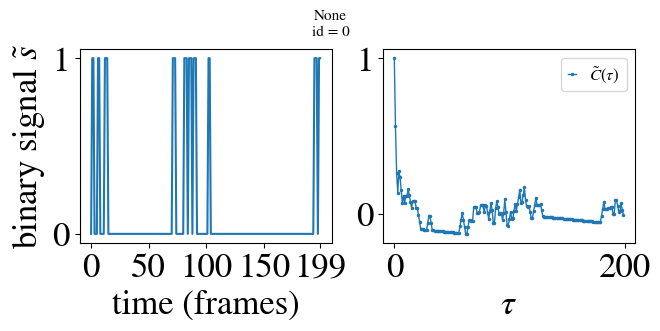

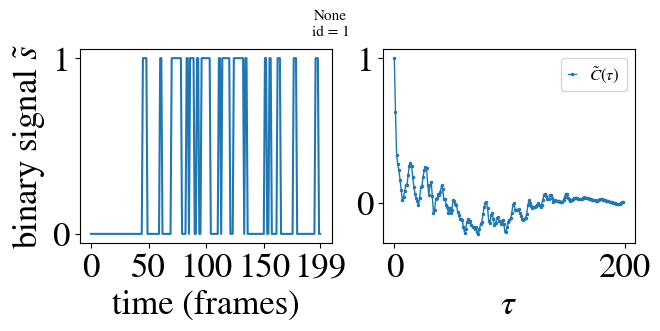

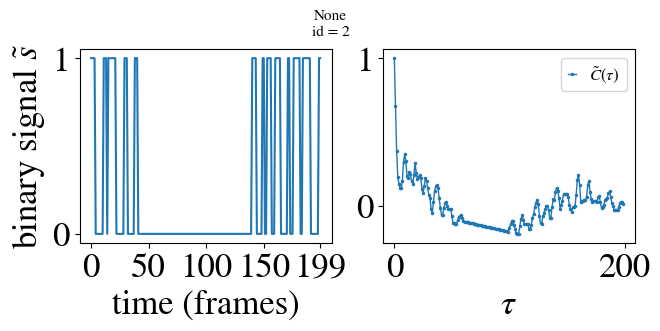

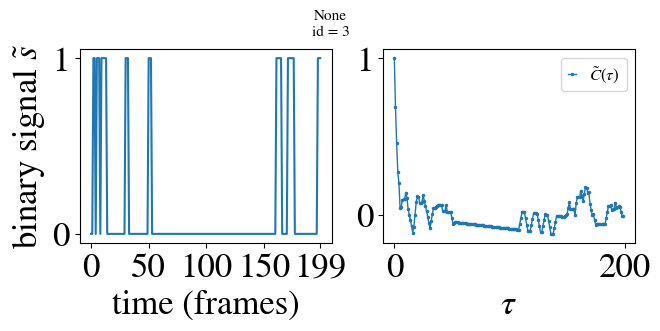

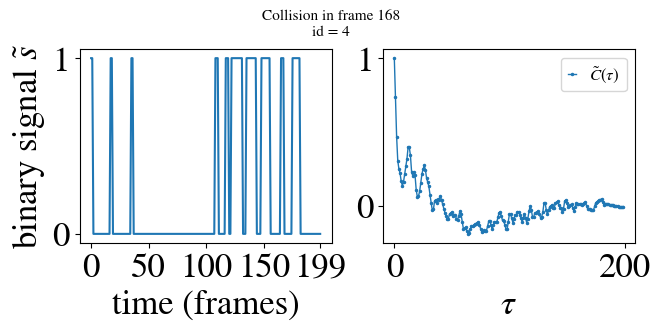

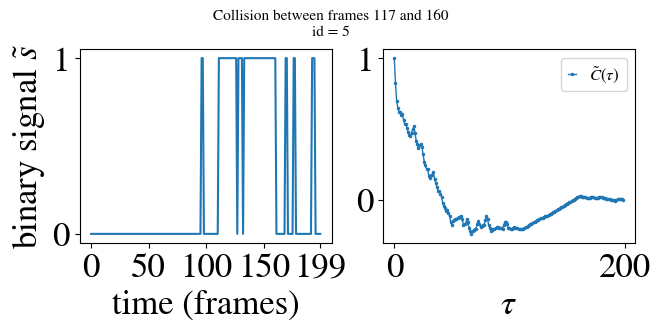

In [218]:
mov_isolated = []
not_mov_isolated = []
zero_cross_isolated = []
zero_cross_mov_isolated = []
zero_cross_not_mov_isolated = []

for id in ids: 
    traj = dataframe[dataframe['Track ID']==id].sort_values('Frame')
    if traj['Info'].values[0] == "Isolated" and id != 16:
        obs = traj['Obs'].values[0]
        speed = traj['speed'].values
        time = traj['Frame'].values
        time_ticks = np.append(time[::50],time[-1])
        
        smooth_speed = smooth_speed_calc(speed)
        not_mov,mov,signal,mask = mov_not_mov(smooth_speed,0.33)
        Corr_signal = autocorrelation(signal)
        Corr_mov = autocorrelation(mov)
        Corr_not_mov = autocorrelation(not_mov)
        zero_cross_mov = find_zero_crossing_lag(Corr_mov)
        zero_cross_not_mov = find_zero_crossing_lag(Corr_not_mov)
        zero_cross_mov_isolated.append(zero_cross_mov)
        zero_cross_not_mov_isolated.append(zero_cross_not_mov)
        
        lags_signal = np.arange(len(signal))
        lags_mov = np.arange(len(mov))
        lags_not_mov = np.arange(len(not_mov))
        tau_zero_cross = find_zero_crossing_lag(Corr_signal)
        color = ['blue' if i==0 else 'red' for i in signal]
        fig, ax = plt.subplots(1,2,figsize=(6.5,3.2),layout='constrained')
        ax[0].plot(time,signal)
        ax[0].set_ylabel(r'binary signal $\tilde{s}$')
        ax[0].set_xlabel('time (frames)')
        ax[0].set_xticks(time_ticks)
        ax[1].plot(lags_signal, Corr_signal, marker='o', ms=1.5, lw=1, label=r'$\tilde{C}(\tau)$')
        # ax[1].plot(lags_mov, Corr_mov, marker='o', ms=1.5, lw=1, label=r'$C_{mov}(\tau)$')
        # ax[1].plot(lags_not_mov, Corr_not_mov, marker='o', ms=1.5, lw=1, label=r'$C_{not\_mov}(\tau)$')
        ax[1].set_xlabel(r'$\tau$')
        ax[1].legend(fontsize=12,handlelength=0.5)
        fig.suptitle(obs+'\n'+f'id = {id}',fontsize=11)
        plt.show()
        mov_isolated += mov
        not_mov_isolated += not_mov
        zero_cross_isolated.append(tau_zero_cross)
        
# plt.figure(figsize=(4,4),layout='constrained')
# plt.hist(mov_isolated,bins='auto',label=f'moving\navg = {np.mean(mov_isolated):.2f}',density=True,alpha=0.6,color='blue',log=True)
# plt.hist(not_mov_isolated, bins='auto', label = f'not moving\navg = {np.mean(not_mov_isolated):.2f}',density=True,alpha=0.4,color='red',log=True)
# plt.xlabel('consecutive\ntime steps (frames)')
# plt.ylabel('Frequency')
# plt.legend(fontsize=16,handlelength=1.5)

# # plt.savefig('./report_imgs/moving_not_moving_distribution_isolated.pdf',bbox_inches = 'tight',dpi=200)
# plt.show()        

# fig, ax = plt.subplots(1, 2, figsize=(8, 4.1), layout='constrained')

# # Left plot: moving / not moving distribution
# ax[0].hist(mov_isolated, bins='auto',
#            label=f'moving\navg = {np.mean(mov_isolated):.2f}',
#            density=True, alpha=0.6, color='blue', log=True)
# ax[0].hist(not_mov_isolated, bins='auto',
#            label=f'not moving\navg = {np.mean(not_mov_isolated):.2f}',
#            density=True, alpha=0.4, color='red', log=True)
# ax[0].set_xlabel('consecutive\ntime steps (frames)')
# ax[0].set_ylabel('Frequency')
# ax[0].legend(fontsize=12, handlelength=1.5)

# # Right plot: zero crossing distribution
# hist_vals, bin_edges = np.histogram(zero_cross_isolated, bins=4, density=True)
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# ax[1].plot(bin_centers, hist_vals, label=f'avg = {np.mean(zero_cross_isolated):.2f}',
#            color='blue', marker='o')
# ax[1].set_xlabel(r'Zero-crossing $\tau^*$')
# # ax[1].set_ylabel('Frequency')
# ax[1].legend(fontsize=12, handlelength=1.5)

# # Save the first figure if needed
# plt.savefig('./report_imgs/zero_crossing_tau_distribution_isolated_and_mov_not_mov_distributions.pdf',bbox_inches = 'tight',dpi=200)


# plt.show()
# plt.figure(figsize=(5,4.5),layout='constrained')
# plt.hist(zero_cross_isolated,bins='auto',label=f'avg = {np.mean(zero_cross_isolated):.2f}',density=True,color='blue',log=True)

# plt.xlabel(r'$\tau^*$')
# plt.ylabel('Frequency')
# plt.legend(fontsize=15,handlelength=1.5)

# # plt.savefig('./report_imgs/zero_crossing_tau_distribution_isolated.pdf',bbox_inches = 'tight',dpi=200)
# plt.show()   

# plt.figure(figsize=(5,4.5),layout='constrained')
# plt.hist(zero_cross_mov_isolated,bins='auto',label=fr'moving $\tau^*$ avg = {np.mean(zero_cross_mov_isolated):.2f}',density=True,color='blue',log=True)
# plt.hist(zero_cross_not_mov_isolated,bins='auto',label=fr'not moving $\tau^*$ avg = {np.mean(zero_cross_not_mov_isolated):.2f}',density=True,color='blue',log=True)

# plt.xlabel(r'$\tau^*$')
# plt.ylabel('Frequency')
# plt.legend(fontsize=15,handlelength=1.5)

# # plt.savefig('./report_imgs/zero_crossing_tau_distribution_isolated.pdf',bbox_inches = 'tight',dpi=200)
# plt.show()



Understanding oscillations in autocorrelation

In [228]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

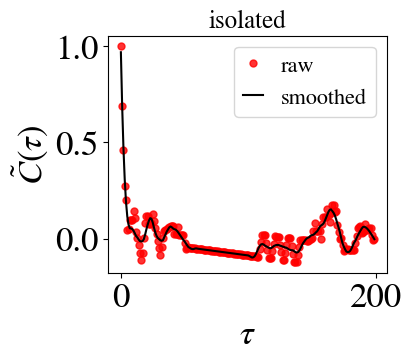

In [269]:
for id in ids: 
    traj = dataframe[dataframe['Track ID']==id].sort_values('Frame')
    obs = traj['Obs'].values[0]
    if traj['Info'].values[0] == "Isolated" and obs == 'None' and id != 16:
        
        speed = traj['speed'].values
        time = traj['Frame'].values
        smooth_speed = smooth_speed_calc(speed)
        not_mov,mov,signal,mask = mov_not_mov(smooth_speed,0.33)
        
        Corr_signal = autocorrelation(signal)
        # Corr_gaussian = gaussian_filter1d(Corr_signal,sigma=4)
        Corr_gaussian = savgol_filter(Corr_signal, window_length=17, polyorder=3)
        lags = np.arange(len(Corr_signal))
        if id == 3:
            isolated_corr = Corr_gaussian
            lags_isolated  =lags
            plt.figure(figsize=(4,3.5),layout='constrained')
            plt.plot(lags,Corr_signal,label='raw',marker='o',ms=5,lw=0.0,color = 'red',alpha=0.8)
            plt.plot(lags,Corr_gaussian,label='smoothed',lw=1.5,color = 'black')
            # plt.title(f'id = {id}',fontsize=18)
            plt.legend(fontsize=16,handlelength=0.9)
            # plt.show()
            plt.xlabel(r'$\tau$')
            plt.ylabel(r'$\tilde{C}(\tau)$')
            # plt.legend(fontsize=16,handlelength=0.5)
            plt.title('isolated',fontsize=18)
            # plt.savefig('data/group-trajectories/second_wave/isolated_autocorrelation_with_smoothing.pdf',bbox_inches='tight',dpi=200)
            plt.show()
    

In [168]:
def chi2_on_integer_data(data1, data2, min_expected_count=5, plot=False,label1='Data 1',label2='Data 2',case=' ',save=False,savename=' ',color1='blue',color2='orange'):
    # Determine max value to cover full range
    max_val = max(np.max(data1), np.max(data2))
    bins = np.arange(0, max_val + 2)  # One bin per integer

    hist1, _ = np.histogram(data1, bins=bins)
    hist2, _ = np.histogram(data2, bins=bins)

    # Mask zero bins in both
    mask = (hist1 + hist2) > 0
    hist1, hist2 = hist1[mask], hist2[mask]

    # Combine bins with low expected counts
    expected = (hist1 + hist2) / 2
    safe_bins1 = []
    safe_bins2 = []

    temp1, temp2 = 0, 0
    for h1, h2, exp in zip(hist1, hist2, expected):
        temp1 += h1
        temp2 += h2
        if temp1 + temp2 >= 2 * min_expected_count:
            safe_bins1.append(temp1)
            safe_bins2.append(temp2)
            temp1, temp2 = 0, 0
    if temp1 + temp2 > 0:  # Add remaining counts to last bin
        safe_bins1[-1] += temp1
        safe_bins2[-1] += temp2

    contingency = np.array([safe_bins1, safe_bins2])
    chi2, pval, _, _ = chi2_contingency(contingency, correction=False)

    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(4.5, 4.1),layout='constrained')
        plt.hist(data1, bins=bins, alpha=0.7, label=label1+f'\navg = {np.average(data1):.2f}',color=color1)
        plt.hist(data2, bins=bins, alpha=0.5, label=label2+f'\navg = {np.average(data2):.2f}',color=color2)
        plt.yscale('log')
        plt.legend(fontsize=15,handlelength=1.5)
        plt.xlabel("Consecutive\ntime steps (frames)")
        plt.ylabel("Frequency")
        plt.title(f"{case}\nChi2 = {chi2:.2f}, p-value = {pval:.5f}",fontsize=17)
        if save:
            plt.savefig(f'data/group-trajectories/second_wave/imgs/{savename}_chi2_test.pdf',bbox_inches = 'tight',dpi=200)
        plt.show()

    return chi2, pval

Statistical Tests in comparisons of groups of 1 and 2: 

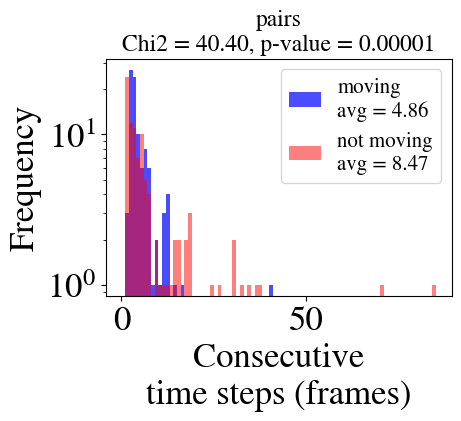

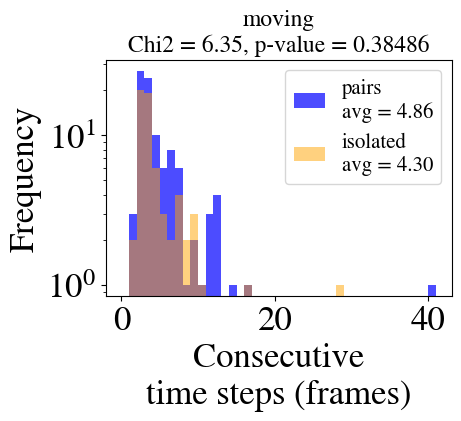

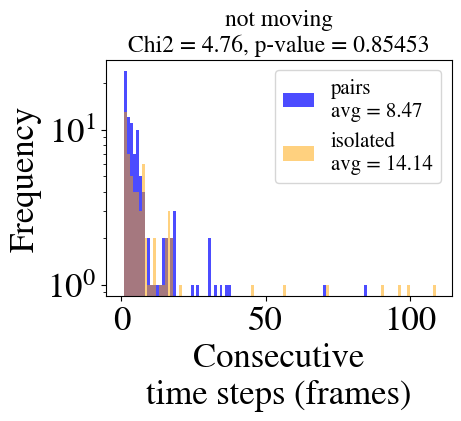

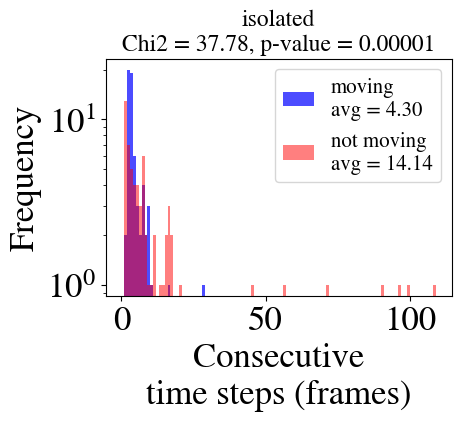

In [198]:
chi2_1,pvalue1 = chi2_on_integer_data(moving_all_pairs, not_moving_all_pairs,plot=True,
                                      label1='moving',label2='not moving', case='pairs',save=False,savename='moving_not_moving_pairs',color1='blue',color2='red')
chi2_2,pvalue2 = chi2_on_integer_data(moving_all_pairs,mov_isolated,plot=True,
                                      label1 = 'pairs',label2= 'isolated',case = 'moving',save=False,savename='moving_pairs_isolated')
chi2_3,pvalue3 = chi2_on_integer_data(not_moving_all_pairs,not_mov_isolated,plot=True,
                                      label1 = 'pairs',label2='isolated',case = 'not moving',save=False,savename='not_moving_pairs_isolated')
chi2_3,pvalue4 = chi2_on_integer_data(mov_isolated,not_mov_isolated,plot=True,
                                      label1 = 'moving',label2 = 'not moving', case = 'isolated',save=False,savename='isolated_moving_not_moving',color1='blue',color2='red')
# print(f'chi2 pairs -> moving vs not moving pairs: {chi2_1:.5f}, p-value: {pvalue1:.5f}')
# print(f'chi2 moving -> pairs vs isolated: {chi2_2:.3f}, p-value: {pvalue2:.3f}')
# print(f'chi2 not moving -> pairs vs isolated: {chi2_3:.3f}, p-value: {pvalue3:.3f}')
# print(f'chi2 isolated -> moving vs not moving: {chi2_3:.5f}, p-value: {pvalue4:.5f}')

Pairs in new data 

In [179]:
import re 

def extract_in_pair_intervals(obs_str):
    intervals = []
    
    # Case: 'In pairs until frame 114'
    match = re.search(r'In pairs until frame (\d+)', obs_str)
    if match:
        end = int(match.group(1))
        intervals.append((0, end))

    # Case: 'In pairs between frames 78 and 139'
    matches = re.findall(r'In pairs between frames (\d+) and (\d+)', obs_str)
    for start, end in matches:
        intervals.append((int(start), int(end)))

    # Case: 'Not in pairs between frames 7 and 32, and frames 141 and 175'
    # => we infer 'in pairs' as complement
    not_in_pairs = re.findall(r'frames (\d+) and (\d+)', obs_str)
    if 'Not in pairs' in obs_str and not_in_pairs:
        not_intervals = [(int(start), int(end)) for start, end in not_in_pairs]
        # Assume a global time range if needed (you can pass this in)
        min_frame, max_frame = 0, 10**6
        # Compute complement
        current = min_frame
        for start, end in sorted(not_intervals):
            if current < start:
                intervals.append((current, start - 1))
            current = end + 1
        if current <= max_frame:
            intervals.append((current, max_frame))

    return intervals
def is_in_pair(frame, obs_str):
    intervals = extract_in_pair_intervals(obs_str)
    return any(start <= frame <= end for start, end in intervals)


In [205]:
ids_pairs = []
for id in ids: 
    traj = dataframe[dataframe['Track ID']==id].sort_values('Frame')
    if traj['Info'].values[0] == 'Pairs':
        ids_pairs.append(id)
        
ids_pairs = np.array(ids_pairs)
ids_pairs = np.reshape(ids_pairs,(len(ids_pairs)//2,2))
ids_pairs

array([[ 6,  7],
       [13, 14],
       [17, 18]])

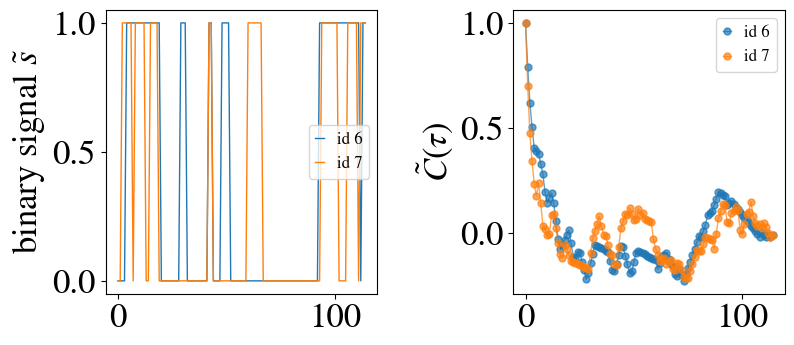

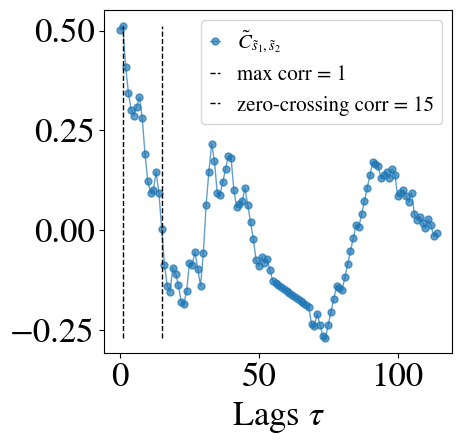

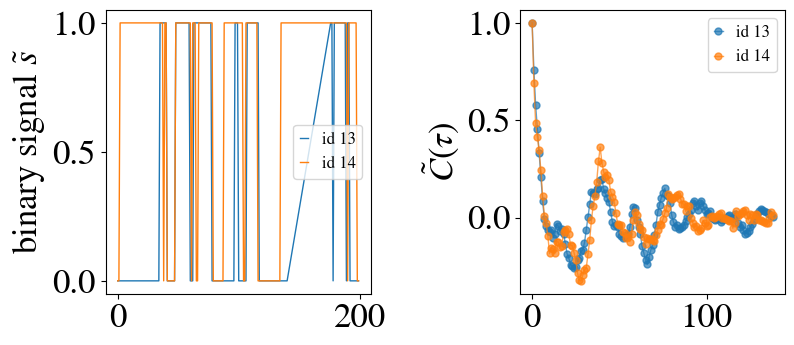

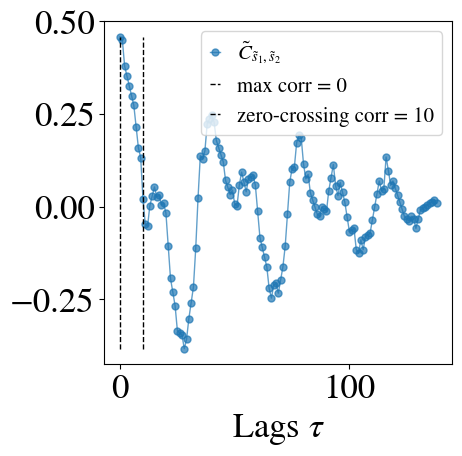

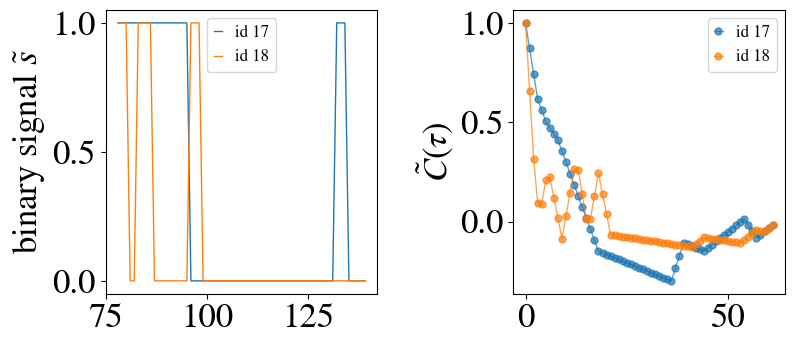

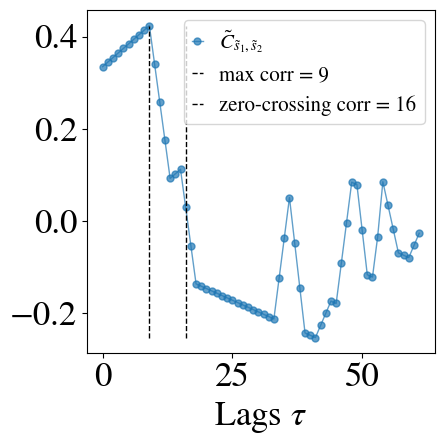

In [213]:
# SECOND SET OF DATA 

moving_all_new=[]
not_moving_all_new = []
zero_cross_all_new = []
max_corr_all_new = []
for i in range(ids_pairs.shape[0]):
    id1,id2 = ids_pairs[i][0],ids_pairs[i][1]
    traj1 = dataframe[dataframe['Track ID']==id1].sort_values('Frame')
    traj2 = dataframe[dataframe['Track ID']==id2].sort_values('Frame')
    
    traj1['IsInPair'] = traj1.apply(lambda row: is_in_pair(row['Frame'], row['Obs']), axis=1)
    traj1_pair = traj1[traj1['IsInPair']]
    traj2['IsInPair'] = traj2.apply(lambda row: is_in_pair(row['Frame'], row['Obs']), axis=1)
    traj2_pair = traj2[traj2['IsInPair']]
    time1 = traj1_pair['Frame'].values
    time2 = traj2_pair['Frame'].values
    
    distance_equal_time = np.sqrt((traj1_pair['x (micron)'].values-traj2_pair['x (micron)'].values)**2 + (traj1_pair['y (micron)'].values-traj2_pair['y (micron)'].values)**2)
    
    smooth_speed1 = smooth_speed_calc(traj1_pair['speed'].values)
    # smooth_speed1 = smooth_speed1/np.max(smooth_speed1)
    smooth_speed2 = smooth_speed_calc(traj2_pair['speed'].values)
    # smooth_speed2 = smooth_speed2/np.max(smooth_speed2)
    
    not_moving1,moving1,signal1,mask1 = mov_not_mov(smooth_speed1,0.33)
    not_moving2,moving2,signal2,mask2 = mov_not_mov(smooth_speed2,0.33)
    color1 = ['blue' if i ==0 else 'red' for i in signal1]
    color2 = ['blue' if i ==0 else 'red' for i in signal2]
    signal1_autocorr = autocorrelation(signal1)
    signal2_autocorr = autocorrelation(signal2)
    lags1 = np.arange(len(signal1_autocorr))
    lags2 = np.arange(len(signal2_autocorr))
    cross_corr_signal = cross_correlation(signal1,signal2)
    max_tau = np.argmax(cross_corr_signal)
    zero_crossing = find_zero_crossing_lag(cross_corr_signal)
    lags = np.arange(-len(signal1)+1, len(signal1))
    moving_all_new.append(moving1+moving2)
    not_moving_all_new.append(not_moving1+not_moving2)
    zero_cross_all_new.append(zero_crossing)
    max_corr_all_new.append(max_tau)

    fig, ax = plt.subplots(1,2,figsize=(8.5,4))
    
    ax[0].plot(time1,signal1,label = f'id {id1}',lw=1.0)
    ax[0].plot(time2,signal2,label = f'id {id2}',lw=1.0)
    ax[0].legend(fontsize=12,handlelength=0.5)
    ax[0].set_ylabel(r'binary signal $\tilde{s}$')
    
    ax[1].plot(lags1,signal1_autocorr,'o-',label=f'id {id1}',lw=1.0,ms=5,alpha=0.7)
    ax[1].plot(lags2,signal2_autocorr,'o-',label=f'id {id2}',lw=1.0,ms=5,alpha=0.7)
    ax[1].set_ylabel(r'$\tilde{C}(\tau)$')
    ax[1].legend(fontsize=12,handlelength=0.5)


    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(5,5))
    plt.plot(lags1,cross_corr_signal,'o-',label=r'$\tilde{C}_{\tilde{s}_1,\tilde{s}_2}$',lw=1.0,ms=5,alpha=0.7)
    plt.vlines(max_tau,min(cross_corr_signal),max(cross_corr_signal),ls='--',color='black',lw=1.0,label= f'max corr = {max_tau}')
    plt.vlines(zero_crossing,min(cross_corr_signal),max(cross_corr_signal),ls='--',color='black',lw=1.0,label= f'zero-crossing corr = {zero_crossing}')

    plt.xlabel(r'Lags $\tau$')
    plt.legend(fontsize=15,handlelength=0.5)
    plt.tight_layout()
    plt.show()
    
    

    

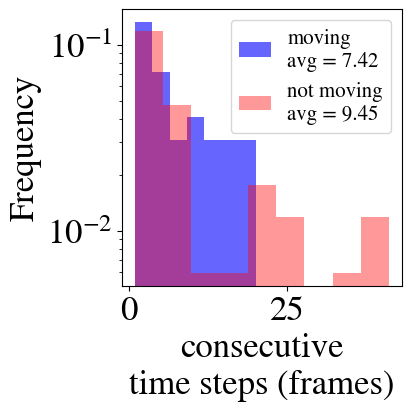

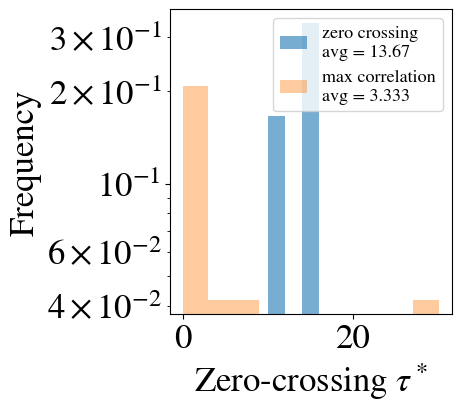

In [214]:
moving_all_pairs_new = np.hstack(moving_all_new)
not_moving_all_pairs_new = np.hstack(not_moving_all_new)

fig1, ax1 = plt.subplots(figsize=(4,4), layout='constrained')

ax1.hist(moving_all_pairs_new, bins='auto',
         label=f'moving\navg = {moving_all_pairs_new.mean():.2f}',
         color='blue', density=True, alpha=0.6)

ax1.hist(not_moving_all_pairs_new, bins='auto',
         label=f'not moving\navg = {not_moving_all_pairs_new.mean():.2f}',
         color='red', density=True, alpha=0.4)

ax1.set_xlabel('consecutive\ntime steps (frames)')
ax1.set_ylabel('Frequency')
ax1.legend(fontsize=15, handlelength=1.5)
ax1.semilogy()

fig1.savefig('data/group-trajectories/second_wave/distribution_moving_not_moving_only_pairs1_v2.pdf',
             bbox_inches='tight', dpi=200)
plt.show()

# Second figure: zero crossing vs. max correlation
fig2, ax2 = plt.subplots(figsize=(4.5,4), layout='constrained')

ax2.hist(zero_cross_all_new, bins='auto',
         label=f'zero crossing\navg = {np.mean(zero_cross_all_new):.2f}',
         density=True, alpha=0.6)

ax2.hist(max_corr_all, bins='auto',
         label=f'max correlation\navg = {np.mean(max_corr_all_new):.3f}',
         density=True, alpha=0.4)

ax2.set_xlabel(r'Zero-crossing $\tau^*$')
ax2.set_ylabel('Frequency')
ax2.legend(fontsize=13, handlelength=1.5)
ax2.semilogy()

fig2.savefig('data/group-trajectories/second_wave/distribution_zero_crossings_maxcorr_pairs1_v2.pdf',
             bbox_inches='tight', dpi=200)
plt.show()

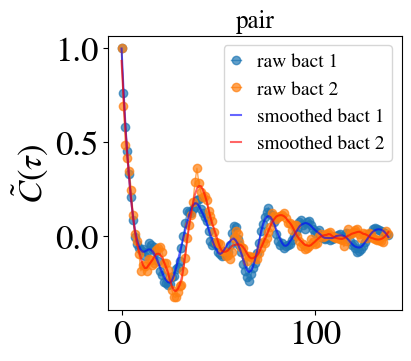

In [270]:
for i in range(ids_pairs.shape[0]):
        id1,id2 = ids_pairs[i][0],ids_pairs[i][1]
        traj1 = dataframe[dataframe['Track ID']==id1].sort_values('Frame')
        traj2 = dataframe[dataframe['Track ID']==id2].sort_values('Frame')

        traj1['IsInPair'] = traj1.apply(lambda row: is_in_pair(row['Frame'], row['Obs']), axis=1)
        traj1_pair = traj1[traj1['IsInPair']]
        traj2['IsInPair'] = traj2.apply(lambda row: is_in_pair(row['Frame'], row['Obs']), axis=1)
        traj2_pair = traj2[traj2['IsInPair']]
        time1 = traj1_pair['Frame'].values
        time2 = traj2_pair['Frame'].values


        smooth_speed1 = smooth_speed_calc(traj1_pair['speed'].values)
        # smooth_speed1 = smooth_speed1/np.max(smooth_speed1)
        smooth_speed2 = smooth_speed_calc(traj2_pair['speed'].values)
        # smooth_speed2 = smooth_speed2/np.max(smooth_speed2)

        not_moving1,moving1,signal1,mask1 = mov_not_mov(smooth_speed1,0.33)
        not_moving2,moving2,signal2,mask2 = mov_not_mov(smooth_speed2,0.33)
        color1 = ['blue' if i ==0 else 'red' for i in signal1]
        color2 = ['blue' if i ==0 else 'red' for i in signal2]
        signal1_autocorr = autocorrelation(signal1)
        signal2_autocorr = autocorrelation(signal2)
        Corr1_smooth = savgol_filter(signal1_autocorr, window_length=17, polyorder=3)
        Corr2_smooth = savgol_filter(signal2_autocorr, window_length=17, polyorder=3)
        lags = np.arange(len(signal1_autocorr))
        if id1 == 13 and id2 == 14:
                pairs_corr1 = Corr1_smooth
                pairs_corr2 = Corr2_smooth
                pairs_lags = lags
                plt.figure(figsize=(4,3.5),layout='constrained')
                plt.plot(lags,signal1_autocorr,'o-',label=f'raw bact 1',lw=1.0,ms=6,alpha=0.7)
                plt.plot(lags,signal2_autocorr,'o-',label=f'raw bact 2 ',lw=1.0,ms=6,alpha=0.7)
                plt.plot(lags,Corr1_smooth,lw=1.5,color='blue',label=f'smoothed bact 1',alpha=0.6)
                plt.plot(lags,Corr2_smooth,lw=1.5,color='red',label=f'smoothed bact 2',alpha=0.6)
                plt.ylabel(r'$\tilde{C}(\tau)$')
                plt.legend(fontsize=14,handlelength=0.5)
                plt.title('pair',fontsize=18)
                # plt.savefig('data/group-trajectories/second_wave/imgs/pairs_autocorrelations_with_smoothing_example.pdf',bbox_inches = 'tight',dpi=200)
                plt.show()
        
                
        

Periodicity and peak detection

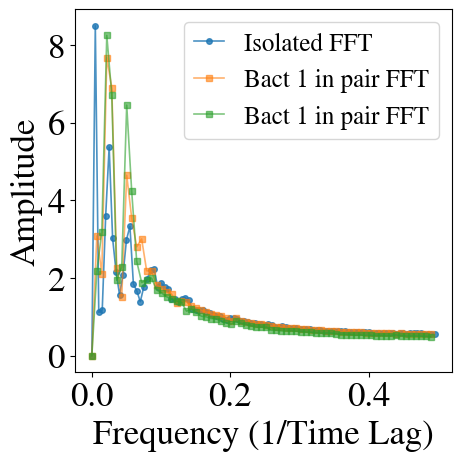

In [286]:
from scipy.fft import fft, fftfreq

def compute_fft(corr, tau):
    s = corr - np.mean(corr)   # Detrend the data
    N = len(s)
    dtau = tau[1] - tau[0]
    fft_vals = fft(s)
    freqs = fftfreq(N, d=dtau)
    return freqs[:N//2], np.abs(fft_vals)[:N//2]

freqs1, fft_amp1 = compute_fft(isolated_corr, lags_isolated)
freqs2, fft_amp2 = compute_fft(pairs_corr1, pairs_lags)
freqs3, fft_amp3 = compute_fft(pairs_corr2, pairs_lags)

plt.figure(figsize=(4.5,4.5),layout='constrained')
plt.plot(freqs1, fft_amp1, label="Isolated FFT",marker='o',ms=4,lw=1.2,alpha=0.8)
plt.plot(freqs2, fft_amp2, label="Bact 1 in pair FFT",marker='s',ms=4,lw=1.2,alpha=0.6)
plt.plot(freqs3, fft_amp3, label="Bact 1 in pair FFT",marker='s',ms=4,lw=1.2,alpha=0.6)

plt.xlabel("Frequency (1/Time Lag)")
plt.ylabel("Amplitude")
plt.legend(fontsize=18,handlelength=1.2)
# plt.title("FFT Comparison")
plt.savefig('data/group-trajectories/second_wave/imgs/autocorrelation_fft_comparison_isolated_pairs.pdf',bbox_inches = 'tight',dpi=200)
plt.show()